# BigTable MTLM for LOA
(Based on Cen 2009)
This model is used to explain the power law in learning.  In this notebook we try to build a neuralised version of the AFM and train it using simulated data.  The aim of using the AFM is to disentangle the latent traits that make up the overall score going into the sigmoid probability estimator.

The model is compensatory, which is a weakness.

In [42]:
from collections import defaultdict, Counter
from copy import copy
from math import exp, sqrt, log
from random import random, shuffle, choice, randint, uniform
import numpy
import math

from keras import Input, Model
from keras.callbacks import EarlyStopping
from keras.constraints import non_neg, max_norm
from numpy import array, ones, floor, ceil
from pandas import concat
from pandas import DataFrame
from keras.models import Sequential
from keras.layers import LSTM, multiply, subtract, add, Activation, Lambda, Flatten, maximum
from keras.layers import Dense, concatenate, MaxPooling1D, LocallyConnected1D, Reshape, Dropout
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras import constraints

import tensorflow as tf

from utils import generate_student_name
import random

from matplotlib import pyplot as plt

n_traits = 2
user_patience = 10


In [43]:
generate_student_name()

'PHUTHY CORE '

In [44]:
from keras import backend as K
from keras.constraints import Constraint
from keras.engine.topology import Layer
from keras import initializers

class WeightClip(Constraint):
    '''Clips the weights incident to each hidden unit to be inside a range
    '''
    def __init__(self, min_w=0, max_w=4):
        self.min_w = min_w
        self.max_w = max_w

    def __call__(self, p):
        return K.clip(p, self.min_w, self.max_w)

    def get_config(self):
        return {'name': self.__class__.__name__,
                'min_w': self.min_w,
                'max_w': self.max_w }

In [45]:
for z in [-20, -10, -4,-3,-2,-1,0,1,2,3,4]:
    print(z, 1/(1+exp(-z)) )

# q_p_avg = 0.45
q_p_easiest = 0.99
q_p_hardest = 0.01
mid = (q_p_easiest + q_p_hardest)/2.0

# pr_k_avg = q_p_avg**(1/n_traits)
# print("pr k avg:", pr_k_avg)

pr_k_easiest = q_p_easiest**(1/n_traits)
pr_k_hardest = q_p_hardest**(1/n_traits)
pr_k_mid = mid**(1/n_traits)

inv_sigmoid = lambda pr : ( -log((1/pr) -1) )
easy_comp_del = inv_sigmoid(pr_k_easiest)
hard_comp_del = inv_sigmoid(pr_k_hardest)

offset = (easy_comp_del - hard_comp_del)/2
baseline = 1
beta_min = baseline+0
# beta_max = baseline+round(offset,1)
# theta_min = baseline+round(easy_comp_del - offset,1)
# theta_max = baseline+round(easy_comp_del,1)
beta_max = baseline+(offset)
theta_min = baseline+(easy_comp_del - offset)
theta_max = baseline+(easy_comp_del)

# beta_min = 0
# beta_max = 10
# theta_min = 5
# theta_max = 15


print(beta_min, beta_max)
print(theta_min, theta_max)

worst_comp_pr = 1/(1+exp(-(theta_min - beta_max)))
best_comp_pr = 1/(1+exp(-(theta_max - beta_min)))

null_task_pr = 1/(1+exp(-baseline))
print("null-task passrate", null_task_pr)
print("all-null passrate", null_task_pr**n_traits)

print("worst cmp chance=", worst_comp_pr)
print("best cmp chance=", best_comp_pr)

print("worst Pr=", worst_comp_pr**n_traits)
print("best Pr=", best_comp_pr**n_traits)

min_min = 1/(1+exp(-(theta_min - beta_min)))
max_max = 1/(1+exp(-(theta_max - beta_max)))
print("limits", min_min, max_max)


nom = array([
    [1,2,3],
    [4,5,6],
    [7,8,9],
])

sel = nom[[0,2]]
print(sel)
print(sel.shape)


-20 2.0611536181902037e-09
-10 4.5397868702434395e-05
-4 0.01798620996209156
-3 0.04742587317756678
-2 0.11920292202211755
-1 0.2689414213699951
0 0.5
1 0.7310585786300049
2 0.8807970779778823
3 0.9525741268224334
4 0.9820137900379085
1 4.744003674264945
2.5467790969287263 6.290782771193672
null-task passrate 0.7310585786300049
all-null passrate 0.534446645388523
worst cmp chance= 0.10000000000000002
best cmp chance= 0.99498743710662
worst Pr= 0.010000000000000004
best Pr= 0.99
limits 0.8244480464246379 0.8244480464246379
[[1 2 3]
 [7 8 9]]
(2, 3)


In [46]:
class BigTable(Layer):

    def __init__(self, _dim, min_w=0, max_w=10, **kwargs):
        self.dim = _dim
        self.limits = (min_w, max_w)
        kc =WeightClip(min_w, max_w)
        self.kernel_constraint= constraints.get(kc)
        super(BigTable, self).__init__(**kwargs)
        
    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        min_w, max_w = self.limits
        av_w = (min_w + max_w)/2.0
        initialiser = initializers.RandomUniform(min_w, max_w)
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(self.dim),
                                      initializer=initialiser,
                                      trainable=True,
                                      constraint=self.kernel_constraint)
        print("kk", self.kernel.shape)
        super(BigTable, self).build(input_shape)  # Be sure to call this at the end

    def call(self, selector):
        print("selector shape", selector.shape)
        selector = K.flatten(selector)
        print("flat selector shape", selector.shape)
        print("call kk", self.kernel.shape)
#         selector = tf.Print(selector, [selector], message="selector is:", first_n=-1, summarize=1024)

        rows = K.gather(self.kernel, selector)
#         rows = tf.Print(rows, [rows], message="row is:", first_n=-1, summarize=1024)
        print("'rows' shape,",rows.shape)
        return rows

    def compute_output_shape(self, input_shape):
        return ((None, self.dim[1]))


In [47]:
# class Question():
#     def __init__(self, qix, min_diff, max_diff, nt=None, nnw=None, optimiser=None):
#         #self.MAX_BETA = 15
#         mass = random.uniform(min_diff*nt,max_diff*nt)
# #         mass = random.choice([(0.8*min_diff+0.2*max_diff)*nt, 0.5*(min_diff+max_diff)*nt, (0.2*min_diff + 0.8*max_diff)*nt])
#         base = min_diff*nt
#         mass = mass - base
        
#         self.id = qix
# #         no_dummies = randint(1,(nt-1))
#         no_live = nt
# #         print("no_dummies=",no_dummies)
# #         self.betas = [ round(random.uniform(min_diff, max_diff),1) for _ in range(nt) ]

#         not_present= min_diff
#         self.betas = [ not_present for _ in range(nt) ]
#         choices = list(range(nt))
#         shuffle(choices)
#         while mass > 0:
#             for c in choices:
#                 curr = self.betas[c]
#                 if curr >= max_diff:
#                     continue
#                 slyce = min(random.uniform(0,max_diff-curr), mass)
#                 mass -= slyce
#                 self.betas[c] += slyce
#                 if mass <= 0:
#                     break       

class Question():
    def __init__(self, qix, min_diff, max_diff, nt=None, nnw=None, optimiser=None):
        self.id = qix

        n_c = numpy.random.choice([1,2], p=[0.33,0.67])
#         n_c = nt
        choices = numpy.random.choice(range(nt), size=n_c, replace=False)
        mass = random.uniform(0,(max_diff-min_diff)*len(choices))

        not_present= min_diff
        self.betas = [ not_present for _ in range(nt) ]        

        for c in choices:
#             self.betas[c] = min_diff
            self.betas[c] = random.uniform(min_diff, max_diff)

In [48]:
# class Student():
#     def __init__(self, psix, min_abil, max_abil, nt=None, nnw=None, optimiser=None):
#         #self.MAX_BETA = 15
#         mass = random.uniform(min_abil*nt,max_abil*nt)
#         base = min_abil*nt
#         mass = mass - base
        
#         self.id = psix
#         self.name = generate_student_name()
# #         min_abil = 0
# #         max_abil = 10
# #         self.thetas = [ round(random.uniform(min_abil, max_abil),1) for _ in range(nt) ]
#         not_present= min_abil
#         self.thetas = [ not_present for _ in range(nt) ]
#         choices = list(range(nt))
#         shuffle(choices)
#         while mass > 0:
#             for c in choices:
#                 curr = self.thetas[c]
#                 if curr >= max_abil:
#                     continue
#                 slyce = min(random.uniform(0,max_abil-curr), mass)
#                 mass -= slyce
#                 self.thetas[c] += slyce
#                 if mass <= 0:
#                     break                  

class Student():
    def __init__(self, ix, min_a, max_a, nt=None, nnw=None, optimiser=None):
        self.id = ix
        self.name = generate_student_name()
        n_c = nt
#         n_c = numpy.random.choice([1,2], p=[0.5,0.5])
        choices = numpy.random.choice(range(nt), size=n_c, replace=False)
        mass = random.uniform(0,(max_a-min_a)*len(choices))

        not_present= min_a
        self.thetas = [ not_present for _ in range(nt) ]        

        for c in choices:
#             self.betas[c] = min_diff
            self.thetas[c] = random.uniform(min_a, max_a)

In [49]:
def attempt_q(student: Student, q: Question):
    p = calculate_pass_probability(student.thetas, q.betas)
    this_att = uniform(0,1)
    if (this_att <= p):
        passed=1
#         print("passed")
#         student.mastery[q.id] = 1
    else:
        passed=0

    return p,passed

In [50]:
def calculate_pass_probability(thetas, betas):
    # additive factors model is:
    # p_pass = 1 / 1 + exp(-z)
    # where z = a + sum[1:n]( -b + gT )
    
    p_pass = 1.0
#     print("th,b",thetas,betas)
    for th,b in zip(thetas,betas):
#         if b == 0:
#             p_pass_step = 1
#         else:
#             if th==0:
#                 print("STUMPED")
#                 p_pass = 0
#                 return p_pass
#             else:
        z = (th-b)
        p_pass_step = exp(z) / (1.0 + exp(z))
#         print(th,"vs",b,"->",z,": ", p_pass_step)
        p_pass *= p_pass_step # simple conjunctive model of success!
    try:
        pass
#         print("p_pass={}".format(p_pass))
    except OverflowError:
        p_pass = 0.0
#     print("real p_pass = {}".format(p_pass))
    return p_pass

In [51]:
qopt = Adam()

# def create_qs(n_qs, nt=n_traits, nnw=n_traits, optimiser=qopt):
#     random.seed(666)
#     master_qs = [Question(qix, beta_min,beta_max, nt=nt, nnw=nnw, optimiser=optimiser) for qix in range(n_qs)]
#     for q in master_qs:
#         nocomps = len(q.betas)
# #         mag = sqrt(sum([ pow(b, 2) for b in q.betas if b!=-10 ]))
#         mag = sum(q.betas)
#         print("Q:{}, difficulty={:.2f} across {} components".format(q.id, mag, nocomps))
#     for q in master_qs:
#         print("qid",q.id,q.betas)
#     qn_table = BigTable((n_qs, nnw),min_w=beta_min, max_w=beta_max)
#     return master_qs, qn_table

def create_qs(n_qs, nt=n_traits, nnw=n_traits, optimiser=qopt):
    random.seed(666)
    numpy.random.seed(666)
    master_qs = [Question(qix, beta_min,beta_max, nt=nt, nnw=nnw, optimiser=optimiser) for qix in range(n_qs)]
    mags = []
    no_comps = []
    for q in master_qs:
        comps = [c for c in q.betas if c>0]
        mag = sqrt(sum([ pow(b, 2) for b in comps ]))
        print("Q:{}, difficulty={:.2f} across {} components".format(q.id, mag, len(comps)))
        mags.append(mag)
        no_comps.append(len(comps))
    
    plt.hist(mags)
    plt.show()
    plt.hist(no_comps)
    plt.show()
    
    for q in master_qs:
        print("qid",q.id,q.betas)
    
    qn_table = BigTable((n_qs, nnw),min_w=beta_min, max_w=beta_max)
    
    return master_qs, qn_table

# Training
This is where sh!t gets real.  We take our tr_len (1000?) students, and iterate over them 100 times to create 100,000 *complete examples* of a student attacking the curriculum.  The questions themselves are attacked in random order: the student has no intelligent guidance throught the material. (Obvious we may wish to provide that guidance at some point in the future.)

Remember, there are only 12 exercises in the curriculum, so if the student is taking 60 or 70 goes to answer them all, that's pretty poor.  But some of these kids are dumb as lumber, so cut them some slack!  They will all get there in the end since by the CMU AFM practice will, eventually, make perfect!

In [52]:
psi_opt = Adam()
def create_students(n_students, nt=n_traits, nnw=n_traits, optimiser=None):
    random.seed(666)
    numpy.random.seed(666)
    psi_list = [ Student(psix, theta_min,theta_max, nt=nt, nnw=nnw, optimiser=optimiser) for psix in range(n_students)]
    for psi in psi_list:
        print(psi.name, psi.thetas)
        
    psi_table = BigTable((n_students, nnw), min_w=theta_min, max_w=theta_max)
    print("psi_table wgts", psi_table.get_weights())
    
    return psi_list, psi_table
    

In [53]:
extend_pop=False
extend_by = 90
if extend_pop:
    for _ in range(extend_by):
        nu_psi = Student(nt=n_traits, nq=len(master_qs), optimiser=psi_opt)
        psi_list.append(nu_psi)

In [54]:
import gc
def generate_attempts(master_qs, psi_list, user_patience=user_patience):
    attempts =[]
    attempts_by_q = {}
    attempts_by_psi = {}

    user_budget = 100 #math.inf
    pass_to_remove = True
    for run in range(1):
        print("----{}\n".format(run))
        for psi in psi_list:
            spend=0
            #psi.mastery = [0 for _ in range(nq)]
            qs = [ix for ix in range(len(master_qs))]
#             print("* * * **** USER {}".format(psi.name))
#             print("* * * * ** THETAS {}".format(psi.thetas))

            while(True):
                q_ct = 0
                qix = random.choice(qs)
                q = master_qs[qix]
                passed=0

                if psi.name not in attempts_by_psi:
                    attempts_by_psi[psi.name]=[]

                if q not in attempts_by_q:
                    attempts_by_q[q]=[]

                while q_ct<user_patience:
                    q_ct+=1
                    pp,passed = attempt_q(psi, q)
                    tup = (psi.id, q.id, passed, (q_ct if passed else 0))
                    attempts.append(tup)
                    if passed:
                        break
                
                print("p_pass was",pp) #, "run p:", 1-(1-pp)**max_atts)
                
                attempts_by_psi[psi.name].append(tup)
                attempts_by_q[q].append(tup)
                                        
                if passed:
                    print("passed in",q_ct)
                    qs.remove(qix)
                else:
                    print("not passed after",q_ct)
                    
                spend += q_ct

                if qs == [] or spend>=user_budget:
                    break
    gc.collect()
    return attempts, attempts_by_q, attempts_by_psi


def generate_qs_model(qn_table, psi_table, optimiser, user_patience=user_patience):
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
#     did_pass = Input(shape=(1,), name="did_pass")
#     did_n = Input(shape=(1,), name="did_n")
    print(qn_table, psi_table, psi_sel, qn_sel)
    print("psi_sel shape", psi_sel.shape)

    psi_table.trainable=True
    qn_table.trainable=True
    
    qn_row = qn_table(qn_sel)
    psi_row = psi_table(psi_sel)
    dif = subtract([psi_row, qn_row])
    print("dif",dif.shape)
    Prs = Lambda(lambda z: K.exp(z) / (1.0 + K.exp(z)), name="sPr_sigmoid")(dif)
    
    print("Prs",Prs.shape)
    #calculate the hazard rate here
    hz = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="sPr_prod")(Prs)
    #pazz = Lambda( lambda p : (1.0-K.pow((1-p),user_patience)), name="pazz_calc" ) (hz)

#     print("hz",hz.shape)
    model = Model(inputs=[qn_sel, psi_sel], outputs=[hz,])
    model.compile(optimizer=optimiser, loss=["binary_crossentropy"], metrics=["accuracy"])#, loss_weights=[1.0,1.0])
    return model

In [55]:
def init_weights(master_qs, psi_list, attempts_by_psi, attempts_by_q, q_table, s_table, min_b, max_b, min_th, max_th):
    numpy.random.seed(666)
    psi_wgts = s_table.get_weights()[0]
    for s in psi_list:
#         attz = [tup[2] for tup in attempts_by_psi[s.name]]
#         prop = mean(attz)
#         p = prop**(1/n_traits)
#         cw_prop = log(p / (1-p))
        av_th = (min_th + max_th)/2.0
#         psi_wgts[s.id,:] = numpy.random.uniform(max_th-1, max_th, size=psi_wgts.shape[1])
        psi_wgts[s.id,:] = numpy.random.uniform(min_th, max_th, size=psi_wgts.shape[1])

        print(psi_wgts[s.id,:])
    s_table.set_weights([ psi_wgts ])

    qn_wgts = q_table.get_weights()[0]
    for q in master_qs:
#         attz = [tup[2] for tup in attempts_by_q[q]]
#         prop = mean(attz)
#         p = prop**(1/n_traits)
#         cw_prop = log((1-p) / p)
        av_b = (min_b + max_b)/2.0
#         qn_wgts[q.id,:]= numpy.random.uniform(min_b, min_b+1, size=qn_wgts.shape[1])
        qn_wgts[q.id,:]= numpy.random.uniform(min_b, max_b, size=qn_wgts.shape[1])

        print(qn_wgts[q.id,:])
    q_table.set_weights([ qn_wgts ])
    

In [56]:
def calc_arr_arr_err(real_wgts, pred_wgts, max_iter=10):
    from scipy.spatial.distance import cosine
# pred_wgts = numpy.round(pred_wgts,1)

    out_cols = [None] * len(real_wgts.T)
    curr_sel = None
    curr_ix = None
    n_iters = 10
    chosen = None

    indices = range(len(real_wgts.T))

    min_total_err = math.inf
    best_cos_dis = math.inf
    for i in range(max_iter): #len(indices)**2):
        real_used = set()
        pred_used = set()
        while len(pred_used) < len(indices):
            curr_err = math.inf
            curr_cos = math.inf
            for rix in numpy.random.permutation(indices):
                if rix in real_used:
                    continue
                real_col = real_wgts.T[rix]
                for cix in numpy.random.permutation(indices):
                    if cix in pred_used:
                        continue
                    pred_col = pred_wgts.T[cix]
                    err = numpy.mean(numpy.abs( pred_col - real_col))
                    #print("mae is ",mse)
                    if err < curr_err:
    #                     print("best match", cix, rix)
    #                     print(real_col)
    #                     print(pred_col)
                        curr_sel = pred_col
                        curr_err = err
                        curr_cos = cosine(pred_col, real_col)
                        curr_ix = cix
                        curr_real_ix = rix
    #         print("---")
            real_used.add(curr_real_ix)
            pred_used.add(curr_ix)
            out_cols[curr_real_ix] = curr_sel
        out_col_arr = array(out_cols).T
        total_err = numpy.mean(numpy.abs( out_col_arr - real_wgts ))
        cos_dis = cosine(out_col_arr.flatten(), real_wgts.flatten())
        mean_ll = numpy.mean( out_col_arr - real_wgts )
#         if total_err < min_total_err:
        if cos_dis < best_cos_dis:
            min_total_err = total_err
            best_ll = mean_ll
            chosen = out_col_arr
            best_cos_dis = cos_dis
#             print("new total min mae:", min_total_err)
#             print("new best ll", best_ll)
    return chosen, min_total_err, mean_ll, best_cos_dis

In [57]:
import os
import IPython

def calibrate(master_qs, psi_list, qs_model, q_model, s_model, attempts, attempts_by_psi, attempts_by_q, s_table, q_table, n_iter=20, record_param_fit=False):
    es = EarlyStopping(monitor="val_loss", mode="auto", patience=0)
    random.seed(666)
    min_mse = 1000
    min_avg_fit_rmse = math.inf
    min_loss= math.inf
    q_outer_mses = []
    q_outer_accs = []
    s_outer_mses = []
    s_outer_accs = []
    th_mses = []
    b_mses = []
    th_accs= []
    b_accs =[]
    h= []
    avg_fit_rmses = []
    th_fit_rmses = []
    b_fit_rmses = []
    init_patience = 20
    patience = init_patience

    print(attempts[0:100])

    qices = array([int(tup[1]) for tup in attempts]).flatten() #reshape(-1,1)
    psices = array([int(tup[0]) for tup in attempts]).flatten() #reshape(-1,1)
    pfs = array([tup[2] for tup in attempts]).flatten() #reshape(-1,1)
    ns = array([tup[3] for tup in attempts]).flatten() #reshape(-1,1)
    len_all = qices.shape[0]
        
    qz = qices
    sz = psices
    pfz = pfs
    nz = ns

#     for pf in pfs:
#         print(pf)
    
    print(qz)
    print(sz)
    print(pfz)
    print(nz)
#     input("Xsan")
    
    loss = False
    mse = False
    acc = False
    early_stop = True
    min_stop = 0
#     n_iter = 1
    for i in range(n_iter):

        base_ix = 0
        done = False
        j = 0
        sub_h = []
        
        qs_model.train_on_batch(x=[qz, sz], y=[pfz,])#, epochs=10, shuffle=True, batch_size=1, callbacks=[es])

        if i % 10 == 0:
            topn=20
            predz = qs_model.predict(x=[qices[0:topn], psices[0:topn]], verbose=0) 
            for j in range(topn):
                print(qices[j], psices[j], pfs[j], ":", predz[j])

            tup = qs_model.evaluate(x=[qices, psices], y=[pfz,], verbose=0) #, epochs=1, shuffle=True, batch_size=1, verbose=0) #, callbacks=[es])
            xhloss, acc = tup
            tup = xhloss, acc, 0,0
            sub_h.append(tup)

            psi_wgts = s_table.get_weights()[0]
            th_rmses = []
            for s in psi_list:
                s_thetas = numpy.sort(s.thetas)
                s_wgts = numpy.sort(psi_wgts[s.id])
                err = numpy.mean( numpy.abs(s_thetas - s_wgts) )
#                 err = cosine(s_thetas, s_wgts)
                th_rmses.append(err)

            qn_wgts = q_table.get_weights()[0]
            b_rmses = []
            for q in master_qs:
                q_betas = numpy.sort(q.betas)
                q_wgts = numpy.sort(qn_wgts[q.id])
                err = numpy.mean( numpy.abs(q_betas - q_wgts) )
#                 err = cosine(q_betas, q_wgts)
                b_rmses.append(err)
            
            print("i =",i)
            th_rmse = numpy.mean(th_rmses)
            th_fit_rmses.append(th_rmse)
            print("th RMSE=", th_rmse)
            b_rmse = numpy.mean(b_rmses)
            b_fit_rmses.append(b_rmse)
            print("b RMSE=", b_rmse)
#             print(loss,pf_loss,mse,acc, n_acc)
            print(mse,acc)
            sub_h = numpy.array(sub_h)
            sub_tup = (sub_h[-1,0],sub_h[-1,1],sub_h[-1,2],sub_h[-1,3])
            h.append(sub_tup)
#             av_rmse = (th_rmse/len(psi_list) +b_rmse/len(master_qs))
#             av_rmse =(th_rmse+b_rmse)/2.0
            av_rmse = b_rmse
            print("av RMSE=",av_rmse)
            if av_rmse < min_avg_fit_rmse:
                patience = init_patience
                print("patience reset to", init_patience)
                min_avg_fit_rmse = av_rmse
                min_loss = loss
                qs_model.save_weights("qs_best_weights_LOA_pf_only.hdf5")
                print("...model saved")
            else:
                if early_stop and i>min_stop:
#                 if loss < min_loss:
#                     print(loss,"<",min_loss)
                    if patience >0:
                        patience -= 1
                        print("patience now", patience)
                    else:
                        print("Earlying stoppin' @",i)
                        break

    #     del h
    #     loss, mse, acc = qs_model.evaluate(x=[qices, psices], y=pfs)

    #     print(loss, mse, acc)
    return h, th_fit_rmses, b_fit_rmses


Q:0, difficulty=5.11 across 2 components
Q:1, difficulty=4.16 across 2 components
Q:2, difficulty=3.95 across 2 components
Q:3, difficulty=4.15 across 2 components
Q:4, difficulty=4.82 across 2 components
Q:5, difficulty=1.70 across 2 components
Q:6, difficulty=4.74 across 2 components
Q:7, difficulty=4.45 across 2 components
Q:8, difficulty=1.66 across 2 components
Q:9, difficulty=2.38 across 2 components
Q:10, difficulty=4.62 across 2 components
Q:11, difficulty=3.94 across 2 components
Q:12, difficulty=1.45 across 2 components
Q:13, difficulty=4.32 across 2 components
Q:14, difficulty=2.14 across 2 components
Q:15, difficulty=5.33 across 2 components
Q:16, difficulty=6.02 across 2 components
Q:17, difficulty=3.94 across 2 components
Q:18, difficulty=4.81 across 2 components
Q:19, difficulty=4.72 across 2 components
Q:20, difficulty=4.66 across 2 components
Q:21, difficulty=3.88 across 2 components
Q:22, difficulty=3.72 across 2 components
Q:23, difficulty=3.75 across 2 components
Q:

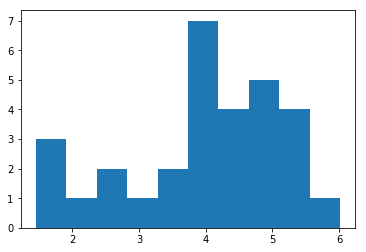

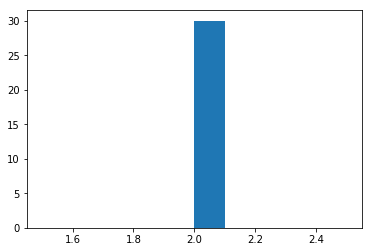

qid 0 [4.382045207550709, 2.626303456145134]
qid 1 [1, 4.037732889636235]
qid 2 [1.461044451595881, 3.6663849490381155]
qid 3 [3.355390001024557, 2.4432897289252216]
qid 4 [4.7021375803577525, 1.0627688047436565]
qid 5 [1.3720800473515755, 1]
qid 6 [4.450694561513504, 1.6356228676023141]
qid 7 [2.5727273151380805, 3.6302155639603364]
qid 8 [1.3233283595299397, 1]
qid 9 [2.16495695690213, 1]
qid 10 [4.374192113230391, 1.487592531168069]
qid 11 [3.7598776002361176, 1.1903499320293132]
qid 12 [1, 1.0522456405500955]
qid 13 [3.8459835623304905, 1.9585963946199083]
qid 14 [1.1288556694421505, 1.814376494242242]
qid 15 [4.482189993857696, 2.8756700368521875]
qid 16 [4.060817932467588, 4.440221935192133]
qid 17 [2.5698454830952935, 2.9914230219825573]
qid 18 [1, 4.702922154904087]
qid 19 [1, 4.616351007731508]
qid 20 [2.536555688861713, 3.9148625678498927]
qid 21 [2.7251367293348627, 2.759851657510133]
qid 22 [2.6917365755118947, 2.5646596609180556]
qid 23 [2.197209714882808, 3.03971229815964

MIHYK COVID  [4.276502082077146, 5.018750912937168]
THYTHYPH FYHA  [3.6304155989317097, 3.073879264392982]
LUTOB GUPH  [4.123057061927159, 2.9427717167038723]
POCH MAL  [4.00137337719086, 2.5886604161745663]
THAD THYSID  [4.314192479793263, 5.42190502876201]
THEG BIM  [5.556580255527677, 5.354269890988922]
FOSO BIC  [3.2226949713798447, 4.164690477968617]
PEG PUP  [3.3531596259863408, 3.627082257792177]
DYPH RAY  [3.99861095187085, 5.65165766737374]
PHEY GED  [3.8126712182008675, 5.073169185474912]
BICHU HUFYT  [3.351287669102935, 6.074305256964591]
GUJI VUW  [5.260346087440136, 3.394398491530307]
DAYAG WYR  [4.609779871428985, 4.731437282645014]
MOCEV DYRYW  [5.157222726014128, 3.3633652382086443]
GOW CHEVA  [3.266725391724964, 5.396008907259061]
RUNE FEFI  [5.866625095360849, 3.2639762110293553]
BOPHEN SUMYCH  [5.244970569940266, 3.888997364558343]
DEGIS CHUGAP  [3.39455624494061, 5.307910304761484]
VYHA YORE  [3.2362516611985708, 3.4124907245566596]
JOFIC VIPIM  [5.488895657191289, 

passed in 1
p_pass was 0.9497991643709945
passed in 1
p_pass was 0.8754509475123232
passed in 1
p_pass was 0.7748313130532886
passed in 1
p_pass was 0.8372092856447362
passed in 2
p_pass was 0.9249032184845113
passed in 1
p_pass was 0.8774440435151488
passed in 1
p_pass was 0.8345418077873731
passed in 1
p_pass was 0.6151533381616705
passed in 1
p_pass was 0.783460961875675
passed in 4
p_pass was 0.6878373627980482
passed in 1
p_pass was 0.7270549135511755
passed in 2
p_pass was 0.438268355657421
passed in 1
p_pass was 0.8339230752822586
passed in 2
p_pass was 0.6737811122326681
passed in 1
p_pass was 0.6684617073570285
passed in 1
p_pass was 0.5664004683254509
passed in 2
p_pass was 0.47532388065616316
passed in 3
p_pass was 0.3380499889484791
passed in 1
p_pass was 0.6853283160241207
passed in 7
p_pass was 0.5471371081392626
passed in 3
p_pass was 0.6943657555513113
passed in 1
p_pass was 0.9326261645954286
passed in 1
p_pass was 0.46176839592806596
passed in 1
p_pass was 0.661024067

passed in 1
p_pass was 0.6561504462422254
passed in 1
p_pass was 0.6947378499191167
passed in 1
p_pass was 0.9163584903988916
passed in 1
p_pass was 0.24255033510849455
passed in 4
p_pass was 0.24519830864829065
passed in 9
p_pass was 0.2615084923272121
passed in 3
p_pass was 0.4188565616904941
passed in 1
p_pass was 0.39910573365551644
passed in 1
p_pass was 0.47550228255094773
passed in 3
p_pass was 0.19343775193022153
passed in 6
p_pass was 0.33780499697140814
passed in 6
p_pass was 0.4277353302773302
passed in 1
p_pass was 0.4854442213012052
passed in 1
p_pass was 0.22520553965889925
passed in 1
p_pass was 0.7501371179295859
passed in 1
p_pass was 0.20602060866453115
passed in 5
p_pass was 0.2662910335885699
passed in 1
p_pass was 0.7735369039765376
passed in 1
p_pass was 0.1918940594148998
passed in 10
p_pass was 0.18622128668811483
not passed after 10
p_pass was 0.5607809884951931
passed in 1
p_pass was 0.618831116357242
passed in 2
p_pass was 0.686324887436416
passed in 1
p_pass

p_pass was 0.9777074431875504
passed in 1
p_pass was 0.7576807603581922
passed in 1
p_pass was 0.8239826248272537
passed in 2
p_pass was 0.9103188697783869
passed in 1
p_pass was 0.9442446201958878
passed in 1
p_pass was 0.9772088659713523
passed in 1
p_pass was 0.7462172344462369
passed in 1
p_pass was 0.8584111426076186
passed in 1
p_pass was 0.6611899329009135
passed in 1
p_pass was 0.680018256349949
passed in 3
p_pass was 0.9647015597135596
passed in 1
p_pass was 0.7870674560839211
passed in 1
p_pass was 0.8047916824787569
passed in 1
p_pass was 0.7713629461410074
passed in 1
p_pass was 0.8206444289014291
passed in 1
p_pass was 0.9074352914817712
passed in 2
p_pass was 0.8391251527783822
passed in 2
p_pass was 0.6225711262093245
passed in 1
p_pass was 0.9798322599333517
passed in 1
p_pass was 0.7082829206276257
passed in 2
p_pass was 0.7892009557745637
passed in 1
p_pass was 0.9646667891990083
passed in 1
p_pass was 0.8809313292721375
passed in 1
p_pass was 0.891212461896325
passed

p_pass was 0.9382341796087184
passed in 1
p_pass was 0.9218613160130575
passed in 1
p_pass was 0.7436121340988522
passed in 1
p_pass was 0.693716904363526
passed in 1
p_pass was 0.7493082418342396
passed in 1
p_pass was 0.6141099493757938
passed in 1
p_pass was 0.885903762484506
passed in 1
p_pass was 0.9376039821498432
passed in 1
p_pass was 0.6951246868908535
passed in 1
p_pass was 0.8160962995875874
passed in 1
p_pass was 0.4903626457643501
passed in 2
p_pass was 0.47744091303224184
passed in 1
p_pass was 0.7162215719336834
passed in 1
p_pass was 0.4894654336442143
passed in 6
p_pass was 0.3169259450694621
passed in 1
p_pass was 0.5024666371120561
passed in 3
p_pass was 0.4588555932394334
passed in 1
p_pass was 0.6075828652609897
passed in 1
p_pass was 0.9299878607586469
passed in 1
p_pass was 0.5767709882757712
passed in 2
p_pass was 0.5595715120995156
passed in 1
p_pass was 0.7388786430679202
passed in 1
p_pass was 0.886800207046594
passed in 1
p_pass was 0.7093204058699303
passed

p_pass was 0.39250517118443007
passed in 1
p_pass was 0.4275586020027477
passed in 4
p_pass was 0.8319127953522664
passed in 1
p_pass was 0.14934288137403207
not passed after 10
p_pass was 0.30566464580073344
passed in 6
p_pass was 0.8370073836581435
passed in 1
p_pass was 0.8041796257337676
passed in 1
p_pass was 0.5829027972205534
passed in 2
p_pass was 0.4685082107973023
passed in 2
p_pass was 0.6400093834696309
passed in 2
p_pass was 0.626291278233097
passed in 2
p_pass was 0.13554157124458557
passed in 8
p_pass was 0.25331593907469363
passed in 1
p_pass was 0.14469979922365475
passed in 8
p_pass was 0.6889459979485394
passed in 2
p_pass was 0.8155484292790859
passed in 1
p_pass was 0.4805128151149908
passed in 2
p_pass was 0.7310953299002491
passed in 1
p_pass was 0.16003741028058588
passed in 6
p_pass was 0.47351077016370213
passed in 4
p_pass was 0.7825683814436177
passed in 1
p_pass was 0.4652315280362407
passed in 1
p_pass was 0.49925983143492925
passed in 1
p_pass was 0.16471

passed in 1
p_pass was 0.38134664776302923
passed in 2
p_pass was 0.881932123249295
passed in 1
p_pass was 0.8922141589363919
passed in 1
p_pass was 0.5374048163972343
passed in 8
p_pass was 0.5351356997850051
passed in 1
p_pass was 0.24274507589757313
passed in 4
p_pass was 0.47954956779647606
passed in 1
p_pass was 0.7655160155181391
passed in 2
p_pass was 0.5284664521999204
passed in 8
p_pass was 0.8918206816778845
passed in 1
p_pass was 0.8001899547568909
passed in 1
p_pass was 0.2719789872648272
passed in 7
p_pass was 0.7921785460985628
passed in 2
p_pass was 0.26552189160166395
passed in 1
p_pass was 0.8701693148793428
passed in 1
p_pass was 0.7168174933561796
passed in 1
p_pass was 0.446883223549421
passed in 2
p_pass was 0.2428167991132839
passed in 8
p_pass was 0.904558401266514
passed in 1
p_pass was 0.8860313538281973
passed in 1
p_pass was 0.875315126453602
passed in 1
p_pass was 0.4793307734456412
passed in 1
p_pass was 0.784972464580249
passed in 2
p_pass was 0.8255251521

passed in 2
p_pass was 0.28790892014183217
passed in 5
p_pass was 0.1880750226580565
passed in 1
p_pass was 0.267450789043842
passed in 2
p_pass was 0.8306641151579393
passed in 1
p_pass was 0.24055617049627734
passed in 6
p_pass was 0.36905898582702595
passed in 3
p_pass was 0.3650633228253156
passed in 1
p_pass was 0.8466980807655491
passed in 1
p_pass was 0.22056239634571134
passed in 3
p_pass was 0.1844386414491487
passed in 1
p_pass was 0.18082231257102385
passed in 4
p_pass was 0.43413626086331863
passed in 2
p_pass was 0.19759756998171588
passed in 4
p_pass was 0.7460998743929803
passed in 1
p_pass was 0.7205493294577429
passed in 1
p_pass was 0.661175747385857
passed in 1
p_pass was 0.9696920027324226
passed in 1
p_pass was 0.809114625018983
passed in 1
p_pass was 0.7787464316964389
passed in 2
p_pass was 0.6080900671092503
passed in 1
p_pass was 0.8774058201264715
passed in 1
p_pass was 0.7314067868324984
passed in 1
p_pass was 0.8483831459008985
passed in 1
p_pass was 0.94913

passed in 2
p_pass was 0.5990239544090152
passed in 1
p_pass was 0.8962271831391351
passed in 1
p_pass was 0.20847731154594765
passed in 1
p_pass was 0.6378703643554966
passed in 1
p_pass was 0.5463249650076949
passed in 1
p_pass was 0.6420821409840376
passed in 2
p_pass was 0.6488703124514238
passed in 1
p_pass was 0.20106929684943042
passed in 1
p_pass was 0.6987154110531771
passed in 2
p_pass was 0.25394337991009147
passed in 1
p_pass was 0.8955665904970654
passed in 1
p_pass was 0.40200484831128974
passed in 1
p_pass was 0.896797977446901
passed in 1
p_pass was 0.3192029643748869
passed in 1
p_pass was 0.5184024886811475
passed in 1
p_pass was 0.6770815357246421
passed in 1
p_pass was 0.7437398959332466
passed in 1
p_pass was 0.9465517758817309
passed in 1
p_pass was 0.7645396391412906
passed in 1
p_pass was 0.8061245621332556
passed in 1
p_pass was 0.8090886216817329
passed in 1
p_pass was 0.8169958759531637
passed in 1
p_pass was 0.6689014972683129
passed in 1
p_pass was 0.783547

passed in 2
p_pass was 0.2267692407481272
passed in 4
p_pass was 0.595326209474665
passed in 1
p_pass was 0.5866805126517757
passed in 2
p_pass was 0.757466319522238
passed in 2
p_pass was 0.8955848980471156
passed in 1
p_pass was 0.21232585066282933
passed in 10
p_pass was 0.24096039072074174
passed in 6
p_pass was 0.8048656925115547
passed in 2
p_pass was 0.45492227152799125
passed in 1
p_pass was 0.41036783524593634
passed in 1
p_pass was 0.37026467573842875
passed in 7
p_pass was 0.5722683577142409
passed in 1
p_pass was 0.2924152670742137
passed in 1
p_pass was 0.187298870738698
passed in 1
p_pass was 0.2321832190575798
not passed after 10
p_pass was 0.6207372412777823
passed in 3
p_pass was 0.8589956648198357
passed in 1
p_pass was 0.7399281705408853
passed in 2
p_pass was 0.8742652268451389
passed in 1
p_pass was 0.8708095365723902
passed in 1
p_pass was 0.2321832190575798
passed in 5
p_pass was 0.21698592165991543
not passed after 10
p_pass was 0.36826049999256055
passed in 1
p

p_pass was 0.3569792392383527
passed in 2
p_pass was 0.5528160928745377
passed in 2
p_pass was 0.746446106947172
passed in 1
p_pass was 0.9179876824190691
passed in 1
p_pass was 0.9212747556474026
passed in 1
p_pass was 0.39316652711045236
passed in 1
p_pass was 0.6095402045183804
passed in 1
p_pass was 0.737149546666067
passed in 3
p_pass was 0.841640320053766
passed in 1
p_pass was 0.7288116789598413
passed in 2
p_pass was 0.9395021954736863
passed in 1
p_pass was 0.8274669519747202
passed in 1
p_pass was 0.3639735417066868
passed in 2
p_pass was 0.30381090483090323
passed in 2
p_pass was 0.712172854826751
passed in 1
p_pass was 0.3753119022144524
passed in 3
p_pass was 0.6955861000941151
passed in 1
p_pass was 0.8166791076736597
passed in 1
p_pass was 0.796973980343249
passed in 1
p_pass was 0.5262676495087264
passed in 1
p_pass was 0.6357849644095362
passed in 2
p_pass was 0.7048154559428235
passed in 1
p_pass was 0.4038346694811466
passed in 3
p_pass was 0.5613444401098054
passed 

p_pass was 0.8538863357408945
passed in 2
p_pass was 0.8348024029738205
passed in 1
p_pass was 0.8719788642158394
passed in 2
p_pass was 0.7704214382738213
passed in 1
p_pass was 0.8783633320649816
passed in 1
p_pass was 0.8531627684097036
passed in 1
p_pass was 0.6763242771208363
passed in 1
p_pass was 0.808795833213441
passed in 1
p_pass was 0.794070787237975
passed in 1
p_pass was 0.7516081348762126
passed in 1
p_pass was 0.9705278548416207
passed in 1
p_pass was 0.6864986630998678
passed in 3
p_pass was 0.8325792456923075
passed in 1
p_pass was 0.8287633860600887
passed in 1
p_pass was 0.9578044851480544
passed in 1
p_pass was 0.9447535149553812
passed in 1
p_pass was 0.5955208009899257
passed in 1
p_pass was 0.9692406476680226
passed in 1
p_pass was 0.739300141637918
passed in 1
p_pass was 0.8816138009040184
passed in 2
p_pass was 0.6770511397772504
passed in 1
p_pass was 0.5418362615724523
passed in 3
p_pass was 0.8483104772813661
passed in 1
p_pass was 0.5158890688439006
passed 

p_pass was 0.14881369820436804
passed in 5
p_pass was 0.5686283242467408
passed in 2
p_pass was 0.7988401532762183
passed in 2
p_pass was 0.2314946513980208
passed in 1
p_pass was 0.9541601153384801
passed in 1
p_pass was 0.7600676143294812
passed in 1
p_pass was 0.7844661323967443
passed in 2
p_pass was 0.686307545454908
passed in 1
p_pass was 0.8396817082842718
passed in 1
p_pass was 0.9559460269910749
passed in 1
p_pass was 0.7491586150466362
passed in 1
p_pass was 0.49935456914921483
passed in 1
p_pass was 0.6614901955790224
passed in 3
p_pass was 0.561620156348768
passed in 1
p_pass was 0.542583452317453
passed in 1
p_pass was 0.8503424560318994
passed in 1
p_pass was 0.9349168897674686
passed in 1
p_pass was 0.6748486164965243
passed in 1
p_pass was 0.7740957141700346
passed in 2
p_pass was 0.5228625559570316
passed in 5
p_pass was 0.8708694742148729
passed in 1
p_pass was 0.5282134734142095
passed in 1
p_pass was 0.8686538562703424
passed in 1
p_pass was 0.9541022457089777
passe

p_pass was 0.4995885234409186
passed in 4
p_pass was 0.668465079159646
passed in 1
p_pass was 0.4727304395249414
passed in 1
p_pass was 0.6697441203416253
passed in 1
p_pass was 0.4349431833285745
passed in 2
p_pass was 0.7519645095066375
passed in 1
p_pass was 0.5374971515076244
passed in 2
p_pass was 0.8291712369276043
passed in 1
p_pass was 0.6187328394223532
passed in 1
p_pass was 0.9369894977703854
passed in 1
p_pass was 0.43790133412422944
passed in 1
p_pass was 0.8903214300618757
passed in 1
p_pass was 0.7765197408273835
passed in 1
p_pass was 0.9485211921137986
passed in 1
p_pass was 0.6916718759978444
passed in 1
p_pass was 0.4831841007825385
passed in 2
p_pass was 0.33599325593309953
not passed after 10
p_pass was 0.7529755785518593
passed in 1
p_pass was 0.49054250005092254
passed in 1
p_pass was 0.2514639935627433
passed in 1
p_pass was 0.19869451022421564
not passed after 10
p_pass was 0.18927553765683727
passed in 6
p_pass was 0.2580953856800579
passed in 4
p_pass was 0.5

passed in 1
p_pass was 0.1500082671839398
passed in 5
p_pass was 0.8554678558333545
passed in 1
p_pass was 0.47721019726066766
passed in 7
p_pass was 0.8411249205653186
passed in 1
p_pass was 0.5140473124456423
passed in 2
p_pass was 0.5458676911340261
passed in 1
p_pass was 0.7630957546156542
passed in 1
p_pass was 0.31226203549244613
passed in 2
p_pass was 0.3300873247737438
not passed after 10
p_pass was 0.2899979436535163
passed in 2
p_pass was 0.1965883797423605
passed in 4
p_pass was 0.8378825754581494
passed in 1
p_pass was 0.18281747708511523
passed in 2
p_pass was 0.10830899691308014
passed in 8
p_pass was 0.3901894430546136
passed in 1
p_pass was 0.43232543790655564
passed in 1
p_pass was 0.34309083418276115
passed in 5
p_pass was 0.672840641615937
passed in 1
p_pass was 0.7675931332577454
passed in 1
p_pass was 0.20589309943546674
passed in 1
p_pass was 0.3113640874559719
passed in 2
p_pass was 0.3300873247737438
passed in 2
p_pass was 0.20489307155270128
passed in 1
p_pass 

passed in 1
p_pass was 0.3058023974254946
passed in 2
p_pass was 0.4016952034959156
passed in 3
p_pass was 0.6565612136846656
passed in 2
p_pass was 0.915323198719973
passed in 2
p_pass was 0.9122827116479987
passed in 2
p_pass was 0.4047737053360848
passed in 2
p_pass was 0.716720384899391
passed in 1
p_pass was 0.6449677380603772
passed in 2
p_pass was 0.2745527104264299
passed in 4
p_pass was 0.48677327613372495
passed in 1
p_pass was 0.6836786221248542
passed in 2
p_pass was 0.8472139525532996
passed in 1
p_pass was 0.883681607018807
passed in 1
p_pass was 0.648770475418618
passed in 1
p_pass was 0.28538286919267203
passed in 6
p_pass was 0.27372444419913455
passed in 3
p_pass was 0.3916731968235295
passed in 3
p_pass was 0.8688892421872316
passed in 2
p_pass was 0.7759691958047104
passed in 1
p_pass was 0.21960757348524473
passed in 2
p_pass was 0.24208360865864356
passed in 2
p_pass was 0.7534839707240288
passed in 1
p_pass was 0.8684306813095383
passed in 1
p_pass was 0.53576846

passed in 3
p_pass was 0.17629056313473065
passed in 1
p_pass was 0.7945085709089961
passed in 1
p_pass was 0.22601237104912772
passed in 4
p_pass was 0.158366306500052
passed in 6
p_pass was 0.655981433302314
passed in 3
p_pass was 0.8403526367945292
passed in 1
p_pass was 0.6543985433120234
passed in 4
p_pass was 0.4758736965646634
passed in 1
p_pass was 0.4551483385174918
passed in 5
p_pass was 0.7270436536690406
passed in 1
p_pass was 0.7952760305651467
passed in 1
p_pass was 0.39646906040340807
passed in 6
p_pass was 0.2575568814530709
passed in 1
p_pass was 0.13696845559140575
not passed after 10
p_pass was 0.2862033719829724
passed in 1
p_pass was 0.36425924170788265
passed in 7
p_pass was 0.5112184621095733
passed in 2
p_pass was 0.1165562190973056
passed in 1
p_pass was 0.17696355807029995
passed in 8
p_pass was 0.190811403745528
not passed after 10
p_pass was 0.17247555654768845
passed in 9
p_pass was 0.3589087617388081
passed in 3
p_pass was 0.6606770709537203
passed in 1
p_

passed in 2
p_pass was 0.31347537879017634
passed in 2
p_pass was 0.9754864296685295
passed in 1
p_pass was 0.769769738881872
passed in 1
p_pass was 0.6793322387682105
passed in 4
p_pass was 0.8860776010077809
passed in 1
p_pass was 0.9601594654475754
passed in 1
p_pass was 0.875935161367417
passed in 2
p_pass was 0.7646802046896694
passed in 1
p_pass was 0.883511504659868
passed in 1
p_pass was 0.7306581789064276
passed in 2
p_pass was 0.761731920507814
passed in 1
p_pass was 0.6421495788380397
passed in 3
p_pass was 0.8779270605693376
passed in 1
p_pass was 0.7601308434440144
passed in 1
p_pass was 0.8257200969401074
passed in 1
p_pass was 0.795170414036975
passed in 1
p_pass was 0.9359996323623796
passed in 1
p_pass was 0.8582592065143038
passed in 1
p_pass was 0.9778252834380988
passed in 1
p_pass was 0.5956269430937561
passed in 2
p_pass was 0.9759595793842508
passed in 1
p_pass was 0.8730967916570919
passed in 1
p_pass was 0.9636092045326267
passed in 2
p_pass was 0.8032486285326

p_pass was 0.49948455744247633
passed in 3
p_pass was 0.44359113095738134
passed in 8
p_pass was 0.38948610815997453
passed in 2
p_pass was 0.30808348777162436
passed in 3
p_pass was 0.32283868374439517
passed in 3
p_pass was 0.24297713138057073
passed in 5
p_pass was 0.1866277155712197
passed in 1
p_pass was 0.707169857117523
passed in 1
p_pass was 0.8754270573470608
passed in 1
p_pass was 0.6568740787370746
passed in 1
p_pass was 0.38550502210361026
passed in 1
p_pass was 0.8915010203340159
passed in 1
p_pass was 0.6108781244702254
passed in 1
p_pass was 0.7817868187000547
passed in 1
p_pass was 0.5229166472129383
passed in 2
p_pass was 0.7812056108995842
passed in 1
p_pass was 0.9151660011320466
passed in 1
p_pass was 0.4211904279169346
passed in 1
p_pass was 0.3013361557887658
passed in 4
p_pass was 0.8009750813010671
passed in 3
p_pass was 0.6893459015324261
passed in 1
p_pass was 0.7324793263812874
passed in 1
p_pass was 0.6674667134976991
passed in 1
p_pass was 0.331129042624113

p_pass was 0.9151955740835651
passed in 2
p_pass was 0.6264566159511227
passed in 1
p_pass was 0.6945506493124192
passed in 2
p_pass was 0.7664261829415401
passed in 2
p_pass was 0.7487504421262975
passed in 2
p_pass was 0.7202740473391979
passed in 1
p_pass was 0.9238947261127497
passed in 3
p_pass was 0.5730020334804988
passed in 2
p_pass was 0.6263152121829768
passed in 1
p_pass was 0.7614845835510927
passed in 1
p_pass was 0.4806105015820965
passed in 1
p_pass was 0.3914443258032177
passed in 2
p_pass was 0.8243288050309822
passed in 1
p_pass was 0.8473034923496363
passed in 2
p_pass was 0.6431618792025762
passed in 1
p_pass was 0.7740159347799503
passed in 1
p_pass was 0.8296651361289129
passed in 1
p_pass was 0.7417699317791335
passed in 1
p_pass was 0.8023812888705051
passed in 1
p_pass was 0.5954301604914333
passed in 1
p_pass was 0.6565676211990384
passed in 1
p_pass was 0.9564624406666713
passed in 2
p_pass was 0.6666233514925965
passed in 1
p_pass was 0.49637218462152616
pas

p_pass was 0.33515824018642226
passed in 2
p_pass was 0.49435571980234455
passed in 1
p_pass was 0.8197798239366472
passed in 2
p_pass was 0.1928596783043726
passed in 3
p_pass was 0.24873401041036522
passed in 1
p_pass was 0.590981235712
passed in 1
p_pass was 0.1798324204306607
passed in 1
p_pass was 0.34710218296992823
passed in 6
p_pass was 0.669313506129759
passed in 1
p_pass was 0.48456350238343743
passed in 1
p_pass was 0.77587240363562
passed in 1
p_pass was 0.8647912512814823
passed in 1
p_pass was 0.2911691008761762
passed in 5
p_pass was 0.44344459643132006
passed in 1
p_pass was 0.5441306622392313
passed in 1
p_pass was 0.5218275778739128
passed in 1
p_pass was 0.20351943086401478
passed in 9
p_pass was 0.13677840029879332
passed in 10
p_pass was 0.5937121442461444
passed in 1
p_pass was 0.5061233473553753
passed in 1
p_pass was 0.8629980315188335
passed in 1
p_pass was 0.41722078333992424
passed in 1
p_pass was 0.3724503800456802
passed in 2
p_pass was 0.3944648963704736
p

p_pass was 0.2930616923556147
passed in 1
p_pass was 0.6110551732102778
passed in 1
p_pass was 0.3141004471671447
passed in 5
p_pass was 0.5779383682409686
passed in 3
p_pass was 0.5643706750710912
passed in 1
p_pass was 0.6016674510859338
passed in 1
p_pass was 0.5217358254549384
passed in 5
p_pass was 0.5051271836385561
passed in 1
p_pass was 0.7923381145421805
passed in 1
p_pass was 0.4884167426224128
passed in 1
p_pass was 0.6902474452756429
passed in 1
p_pass was 0.8058778877186197
passed in 2
p_pass was 0.42748304321294434
passed in 1
p_pass was 0.5639234369943684
passed in 1
p_pass was 0.29512267413481
passed in 6
p_pass was 0.09172786216826716
passed in 1
p_pass was 0.8377687450740181
passed in 1
p_pass was 0.35352594868516923
passed in 3
p_pass was 0.20093799278806154
passed in 1
p_pass was 0.2244326491759556
passed in 1
p_pass was 0.17402704409689865
not passed after 10
p_pass was 0.28135492693220004
not passed after 10
p_pass was 0.1504756276977895
passed in 9
p_pass was 0.2

passed in 2
p_pass was 0.5977382197544194
passed in 4
p_pass was 0.5675289059137267
passed in 1
p_pass was 0.859879577306138
passed in 2
p_pass was 0.6475807641407924
passed in 2
p_pass was 0.923774766652365
passed in 1
p_pass was 0.7507853207806928
passed in 1
p_pass was 0.9463244196975324
passed in 1
p_pass was 0.7564441555758867
passed in 2
p_pass was 0.7681740324818909
passed in 1
p_pass was 0.6117097814751968
passed in 2
p_pass was 0.5263152965231745
passed in 1
p_pass was 0.9505517389664523
passed in 1
p_pass was 0.7832842141426555
passed in 1
p_pass was 0.6479757458485556
passed in 2
p_pass was 0.7356720236662788
passed in 2
p_pass was 0.7433663283056879
passed in 1
p_pass was 0.5672173445255141
passed in 1
p_pass was 0.6276571165412205
passed in 1
p_pass was 0.9112803727412564
passed in 1
p_pass was 0.6962343248748598
passed in 1
p_pass was 0.46062712327454336
passed in 2
p_pass was 0.36280178806340696
not passed after 10
p_pass was 0.3399751677551793
passed in 2
p_pass was 0.6

passed in 2
p_pass was 0.4653581509175831
passed in 4
p_pass was 0.6650989904113154
passed in 2
p_pass was 0.8956694816329864
passed in 1
p_pass was 0.8395926983511256
passed in 2
p_pass was 0.3360708834967172
passed in 2
p_pass was 0.42289865178477026
passed in 1
p_pass was 0.5502455056860305
passed in 3
p_pass was 0.7567116353859401
passed in 1
p_pass was 0.5781635506610062
passed in 5
p_pass was 0.3554815809282589
passed in 1
p_pass was 0.37768802431455367
passed in 1
p_pass was 0.8025959365723306
passed in 1
p_pass was 0.8193101622700852
passed in 2
p_pass was 0.33373337558666805
passed in 2
p_pass was 0.916181609983669
passed in 1
p_pass was 0.8781612537423508
passed in 1
p_pass was 0.637099615919643
passed in 5
p_pass was 0.5052243318681637
passed in 1
p_pass was 0.898964889242713
passed in 1
p_pass was 0.3659169078069457
passed in 1
p_pass was 0.6404304918066329
passed in 1
p_pass was 0.29067319443833234
passed in 3
p_pass was 0.5050967686713442
passed in 2
p_pass was 0.32147604

passed in 1
p_pass was 0.9655055756739049
passed in 1
p_pass was 0.9404544284355805
passed in 1
p_pass was 0.6763400254962028
passed in 6
p_pass was 0.8882809970396712
passed in 1
p_pass was 0.8436163038747138
passed in 1
p_pass was 0.7321708179326211
passed in 1
p_pass was 0.7711153656261701
passed in 1
p_pass was 0.7666013661917541
passed in 1
p_pass was 0.6843554972059789
passed in 1
p_pass was 0.9717661996505775
passed in 1
p_pass was 0.9368571229925127
passed in 1
p_pass was 0.9756254195590915
passed in 1
p_pass was 0.6910421298540818
passed in 1
p_pass was 0.800793882840597
passed in 1
p_pass was 0.5735768672365601
passed in 1
p_pass was 0.9167691538356093
passed in 1
p_pass was 0.9587699012442219
passed in 1
p_pass was 0.6996484983312591
passed in 2
p_pass was 0.6380246743071282
passed in 1
p_pass was 0.6573926614552269
passed in 1
p_pass was 0.7484267141911838
passed in 1
p_pass was 0.8989454772387211
passed in 1
p_pass was 0.8227879526235837
passed in 1
p_pass was 0.8511974930

passed in 1
p_pass was 0.6449524424086063
passed in 1
p_pass was 0.4399541411997108
passed in 2
p_pass was 0.3845088198928004
passed in 2
p_pass was 0.29598647073679724
passed in 1
p_pass was 0.35243592491981074
passed in 2
p_pass was 0.08877385195676302
passed in 6
p_pass was 0.22215661354000613
passed in 2
p_pass was 0.18713918773935753
not passed after 10
p_pass was 0.18713918773935753
passed in 1
p_pass was 0.5727335903123567
passed in 1
p_pass was 0.2497185823808508
passed in 2
p_pass was 0.1745316939442359
passed in 6
p_pass was 0.2965372472731358
passed in 7
p_pass was 0.34126577305622124
passed in 1
p_pass was 0.17128880717935724
passed in 5
p_pass was 0.470450670128773
passed in 1
p_pass was 0.5136733333407174
passed in 1
p_pass was 0.4052223131997591
passed in 2
p_pass was 0.24728217772262465
passed in 1
p_pass was 0.8361599038878161
passed in 2
p_pass was 0.20201162990032523
passed in 4
p_pass was 0.5204946854423629
passed in 3
p_pass was 0.6358198940865482
passed in 1
p_pas

p_pass was 0.6740170712498409
passed in 1
p_pass was 0.8497692655440425
passed in 2
p_pass was 0.9302453267319469
passed in 1
p_pass was 0.5530740501177035
passed in 2
p_pass was 0.41703344751743743
passed in 1
p_pass was 0.4594786757728666
passed in 2
p_pass was 0.37593259716910676
passed in 1
p_pass was 0.8273919804953311
passed in 1
p_pass was 0.36468221866411427
passed in 1
p_pass was 0.4035206244807026
passed in 1
p_pass was 0.8218751911263993
passed in 2
p_pass was 0.3750896237352021
passed in 3
p_pass was 0.24584656424580853
passed in 5
p_pass was 0.460537690053934
passed in 2
p_pass was 0.6979786847896544
passed in 1
p_pass was 0.4825581916606713
passed in 1
p_pass was 0.6756391576993243
passed in 1
p_pass was 0.861834554825705
passed in 1
p_pass was 0.8775869925658621
passed in 2
p_pass was 0.6526850615617195
passed in 1
p_pass was 0.914781605493306
passed in 1
p_pass was 0.9246835785758772
passed in 1
p_pass was 0.4886269110128301
passed in 2
p_pass was 0.5887602237740813
pas

p_pass was 0.855184061290038
passed in 1
p_pass was 0.6230068585029759
passed in 1
p_pass was 0.6727852349734696
passed in 2
p_pass was 0.7973559282252451
passed in 3
p_pass was 0.764704265441761
passed in 3
p_pass was 0.9237907078048051
passed in 1
p_pass was 0.9102450189353599
passed in 2
p_pass was 0.7160895460703774
passed in 1
p_pass was 0.5344000385679327
passed in 1
p_pass was 0.5201591028500241
passed in 9
p_pass was 0.676997262183833
passed in 1
p_pass was 0.9532920924252027
passed in 1
p_pass was 0.4972241583310522
passed in 4
p_pass was 0.7318688339493233
passed in 1
p_pass was 0.7768250516250316
passed in 1
p_pass was 0.7827876604162727
passed in 1
p_pass was 0.5586470004236167
passed in 3
p_pass was 0.5060308080050452
passed in 2
p_pass was 0.7134730521951563
passed in 1
p_pass was 0.6467720865684722
passed in 1
p_pass was 0.9465501692940215
passed in 1
p_pass was 0.5091766707656271
passed in 1
p_pass was 0.8876535257253776
passed in 1
p_pass was 0.8250905020636167
passed 

p_pass was 0.4999591514664157
passed in 3
p_pass was 0.6799211259429556
passed in 2
p_pass was 0.23086370749507318
passed in 6
p_pass was 0.6459696112326377
passed in 1
p_pass was 0.8845754536746687
passed in 1
p_pass was 0.545182810897711
passed in 1
p_pass was 0.6596073179852772
passed in 2
p_pass was 0.7266003032831163
passed in 1
p_pass was 0.3431506588983693
passed in 2
p_pass was 0.19602411322782956
passed in 2
p_pass was 0.21670732928289552
passed in 2
p_pass was 0.577715086484233
passed in 5
p_pass was 0.5263871309600198
passed in 1
p_pass was 0.357728200942315
passed in 4
p_pass was 0.8398802458881796
passed in 1
p_pass was 0.5611140816899198
passed in 1
p_pass was 0.2585102122744231
passed in 6
p_pass was 0.2457107364381909
passed in 2
p_pass was 0.759504478008103
passed in 1
p_pass was 0.5256369496114923
passed in 1
p_pass was 0.8171140135225883
passed in 3
p_pass was 0.8475429886857931
passed in 1
p_pass was 0.8531283478955382
passed in 1
p_pass was 0.8549551417264061
passe

p_pass was 0.11404803913788766
passed in 1
p_pass was 0.586567167831196
passed in 2
p_pass was 0.6799767177358031
passed in 1
p_pass was 0.10924492937506698
not passed after 10
p_pass was 0.9372319253090194
passed in 1
p_pass was 0.5264513823118487
passed in 1
p_pass was 0.7605156077179388
passed in 2
p_pass was 0.47767076785122875
passed in 2
p_pass was 0.5746904400557411
passed in 2
p_pass was 0.31991105305852635
passed in 2
p_pass was 0.3361747155424544
passed in 4
p_pass was 0.6203205569575921
passed in 1
p_pass was 0.7331786358268602
passed in 1
p_pass was 0.8530389467104635
passed in 1
p_pass was 0.6965055843364186
passed in 3
p_pass was 0.554720796109063
passed in 2
p_pass was 0.6171848150004134
passed in 1
p_pass was 0.7207426424515403
passed in 3
p_pass was 0.7406895749676524
passed in 1
p_pass was 0.8648735152833569
passed in 1
p_pass was 0.9122697466678182
passed in 1
p_pass was 0.35271742387895394
passed in 3
p_pass was 0.9193740105620734
passed in 1
p_pass was 0.3881481408

passed in 2
p_pass was 0.7225765222078465
passed in 1
p_pass was 0.7536371647615591
passed in 2
p_pass was 0.7622381310786558
passed in 1
p_pass was 0.9770025669800497
passed in 1
p_pass was 0.9115999261861709
passed in 2
p_pass was 0.8196040045668769
passed in 1
p_pass was 0.896227591734256
passed in 1
p_pass was 0.8531598518823453
passed in 1
p_pass was 0.879169488251861
passed in 1
p_pass was 0.26076974400453345
passed in 6
p_pass was 0.3074815975581299
passed in 4
p_pass was 0.37701402334553197
passed in 1
p_pass was 0.33647087990688485
passed in 1
p_pass was 0.45890954744301105
passed in 1
p_pass was 0.2531894472912808
passed in 2
p_pass was 0.40170780404903594
passed in 3
p_pass was 0.11513438455661695
passed in 5
p_pass was 0.12673402568710596
passed in 1
p_pass was 0.35732020127085207
passed in 2
p_pass was 0.20031573103129005
passed in 2
p_pass was 0.673014754421341
passed in 1
p_pass was 0.7606958356342088
passed in 1
p_pass was 0.05631801879460921
passed in 4
p_pass was 0.65

passed in 2
p_pass was 0.5431339040256528
passed in 3
p_pass was 0.656813755721909
passed in 1
p_pass was 0.9272872407418854
passed in 2
p_pass was 0.7340498229170087
passed in 1
p_pass was 0.5245289903973849
passed in 2
p_pass was 0.7990605696100054
passed in 1
p_pass was 0.6064729915717472
passed in 2
p_pass was 0.5775851456363645
passed in 1
p_pass was 0.3552416016468566
passed in 1
p_pass was 0.7047416319537432
passed in 1
p_pass was 0.9043619404144101
passed in 1
p_pass was 0.7665142475276913
passed in 2
p_pass was 0.627550841389472
passed in 1
p_pass was 0.9694278319020593
passed in 1
p_pass was 0.767067413372425
passed in 1
p_pass was 0.7458730472376701
passed in 2
p_pass was 0.5658964972220895
passed in 3
p_pass was 0.968211597308089
passed in 1
p_pass was 0.8124308828766206
passed in 1
p_pass was 0.9594135504834751
passed in 1
p_pass was 0.6589291966689844
passed in 4
p_pass was 0.8513054080798306
passed in 1
p_pass was 0.6087476489749478
passed in 3
p_pass was 0.6831265726733

passed in 1
p_pass was 0.8029523747366941
passed in 2
p_pass was 0.6367665011848275
passed in 1
p_pass was 0.6792164460536273
passed in 2
p_pass was 0.8074478221976241
passed in 1
p_pass was 0.7173691455849898
passed in 1
p_pass was 0.8532324504469209
passed in 1
p_pass was 0.8677387925966152
passed in 1
p_pass was 0.6535736108823345
passed in 1
p_pass was 0.6298883431004954
passed in 2
p_pass was 0.6973089792256759
passed in 1
p_pass was 0.9709376706538444
passed in 1
p_pass was 0.8441985886234775
passed in 1
p_pass was 0.9436325764818305
passed in 1
p_pass was 0.524855274605536
passed in 1
p_pass was 0.7488108384383769
passed in 1
p_pass was 0.821062611553779
passed in 1
p_pass was 0.8379496785908289
passed in 1
p_pass was 0.5752172452185785
passed in 2
p_pass was 0.9073213781087159
passed in 1
p_pass was 0.9248548606382827
passed in 1
p_pass was 0.9710680503331527
passed in 1
p_pass was 0.6729650200335865
passed in 1
p_pass was 0.691206420837689
passed in 1
p_pass was 0.652443793169

passed in 1
p_pass was 0.1623838285930662
passed in 1
p_pass was 0.3462017629030199
passed in 3
p_pass was 0.8009937769301676
passed in 2
p_pass was 0.14872644119847483
passed in 2
p_pass was 0.2354414269875619
passed in 2
p_pass was 0.26206100204401794
passed in 5
p_pass was 0.40751804226028004
passed in 4
p_pass was 0.16774613531448973
passed in 8
p_pass was 0.157767347194275
passed in 2
p_pass was 0.07829896474998502
not passed after 10
p_pass was 0.5418707048018561
passed in 1
p_pass was 0.8222749675081029
passed in 2
p_pass was 0.36240562821249706
passed in 2
p_pass was 0.2130697941600356
passed in 7
p_pass was 0.14026956087785925
passed in 2
p_pass was 0.2854602656264426
passed in 2
p_pass was 0.32432674798545386
passed in 1
p_pass was 0.4826878699588519
passed in 1
p_pass was 0.22618297637848608
passed in 4
p_pass was 0.7134352390791069
passed in 1
p_pass was 0.18767675054995905
passed in 4
p_pass was 0.4106185919728386
passed in 1
p_pass was 0.44428049502873296
passed in 1
p_pa

p_pass was 0.7162729973778666
passed in 1
p_pass was 0.8451232748748522
passed in 1
p_pass was 0.558549889720092
passed in 3
p_pass was 0.5969274762184358
passed in 1
p_pass was 0.8150615208085191
passed in 1
p_pass was 0.533627902820092
passed in 1
p_pass was 0.7728761065820254
passed in 2
p_pass was 0.95913017917053
passed in 1
p_pass was 0.578040628843239
passed in 2
p_pass was 0.8512252583706439
passed in 2
p_pass was 0.8544540946775949
passed in 1
p_pass was 0.2734888111207633
passed in 8
p_pass was 0.7601232893358971
passed in 1
p_pass was 0.25459548275901434
passed in 5
p_pass was 0.21983053245749545
passed in 4
p_pass was 0.16894985433469686
passed in 8
p_pass was 0.5113678267468219
passed in 1
p_pass was 0.14989598029992682
passed in 3
p_pass was 0.5065097999277256
passed in 1
p_pass was 0.1794009900487903
passed in 8
p_pass was 0.6981154137708688
passed in 1
p_pass was 0.18438743172660088
passed in 1
p_pass was 0.4991938634477317
passed in 3
p_pass was 0.3538262599622922
pass

p_pass was 0.565697008785796
passed in 1
p_pass was 0.7489932564964271
passed in 1
p_pass was 0.9399515344075685
passed in 1
p_pass was 0.4453366729706756
passed in 2
p_pass was 0.9471358772919495
passed in 1
p_pass was 0.6610325234829884
passed in 1
p_pass was 0.5874999644050414
passed in 1
p_pass was 0.3436192275638577
passed in 1
p_pass was 0.7772822885306775
passed in 1
p_pass was 0.42441053546608587
passed in 4
p_pass was 0.5206884938603168
passed in 1
p_pass was 0.7529059800658907
passed in 1
p_pass was 0.585617268222605
passed in 1
p_pass was 0.9072939813280028
passed in 1
p_pass was 0.6144811543085016
passed in 1
p_pass was 0.7343812314888323
passed in 1
p_pass was 0.9102801075478927
passed in 1
p_pass was 0.5710351098456293
passed in 1
p_pass was 0.6270785668106235
passed in 1
p_pass was 0.8639213693626875
passed in 1
p_pass was 0.4558145378335962
passed in 2
p_pass was 0.6763069046390521
passed in 1
p_pass was 0.6260566988960239
passed in 1
p_pass was 0.9066519227041804
passe

p_pass was 0.8960955786752559
passed in 1
p_pass was 0.39952724676027984
passed in 1
p_pass was 0.8746081815064523
passed in 1
p_pass was 0.8794102186505559
passed in 1
p_pass was 0.6320994948199341
passed in 1
p_pass was 0.27168237965882414
passed in 1
p_pass was 0.8080902387964183
passed in 1
p_pass was 0.48971348992217745
passed in 4
p_pass was 0.2561223489709239
passed in 4
p_pass was 0.28742520977267183
passed in 5
p_pass was 0.41898241948305154
passed in 2
p_pass was 0.7679887932044811
passed in 1
p_pass was 0.5980711836468862
passed in 1
p_pass was 0.2594515247622851
passed in 1
p_pass was 0.3151732289988339
passed in 7
p_pass was 0.4086407809242422
passed in 2
p_pass was 0.732286670494516
passed in 1
p_pass was 0.6363607554121653
passed in 1
p_pass was 0.745492390076096
passed in 1
p_pass was 0.7057297890321066
passed in 2
p_pass was 0.8739469177493848
passed in 1
p_pass was 0.857045077607331
passed in 1
p_pass was 0.614786410009295
passed in 4
p_pass was 0.8834821840427434
pas

p_pass was 0.8124828140181832
passed in 1
p_pass was 0.48935205753808547
passed in 2
p_pass was 0.2770669359234491
passed in 4
p_pass was 0.2316206202069003
passed in 1
p_pass was 0.12651660787577512
passed in 3
p_pass was 0.1427129684748786
not passed after 10
p_pass was 0.187700737455562
passed in 6
p_pass was 0.26130105323974334
passed in 3
p_pass was 0.7401461050036258
passed in 2
p_pass was 0.43221208625265795
passed in 1
p_pass was 0.20137139015023497
passed in 3
p_pass was 0.08398249597596939
not passed after 10
p_pass was 0.2317723457513551
passed in 5
p_pass was 0.07872076781860701
not passed after 10
p_pass was 0.10770293395771985
passed in 1
p_pass was 0.03869340072451237
not passed after 10
p_pass was 0.07880966350639261
not passed after 10
p_pass was 0.6174032641705575
passed in 3
p_pass was 0.10328842870997343
not passed after 10
p_pass was 0.1427129684748786
passed in 6
p_pass was 0.17691294785519657
passed in 8
p_pass was 0.5246958136318347
passed in 2
p_pass was 0.4170

passed in 1
p_pass was 0.791790337097391
passed in 1
p_pass was 0.7694204759342738
passed in 1
p_pass was 0.6698445494877406
passed in 1
p_pass was 0.5799114268323974
passed in 3
p_pass was 0.9208290543967141
passed in 2
p_pass was 0.7969110135123983
passed in 1
p_pass was 0.9573781150978532
passed in 1
p_pass was 0.4511776983222793
passed in 2
p_pass was 0.6178732098679344
passed in 1
p_pass was 0.9057902791222963
passed in 3
p_pass was 0.5919835380099286
passed in 3
p_pass was 0.4516498870439475
passed in 3
p_pass was 0.5938074462410494
passed in 1
p_pass was 0.5552342019894042
passed in 1
p_pass was 0.3882803651139435
passed in 2
p_pass was 0.625969828853216
passed in 2
p_pass was 0.6283343932090115
passed in 1
p_pass was 0.28936416895338807
passed in 3
p_pass was 0.7519224764006699
passed in 2
p_pass was 0.8384967705371816
passed in 1
p_pass was 0.5300144955524377
passed in 1
p_pass was 0.4033040204209997
passed in 3
p_pass was 0.8734638331090206
passed in 2
p_pass was 0.6424831076

passed in 1
p_pass was 0.9830407023763313
passed in 2
p_pass was 0.9627634156921079
passed in 1
p_pass was 0.878653420636506
passed in 1
p_pass was 0.7995274329348567
passed in 1
p_pass was 0.8965083096719274
passed in 1
p_pass was 0.986037117560244
passed in 1
p_pass was 0.978915417434831
passed in 1
p_pass was 0.7748257329977616
passed in 1
p_pass was 0.8574377877450986
passed in 1
p_pass was 0.9353204109096376
passed in 1
p_pass was 0.9251860523539502
passed in 1
p_pass was 0.9677409551088171
passed in 1
p_pass was 0.9528190988700233
passed in 1
p_pass was 0.8222175293320717
passed in 2
p_pass was 0.2565146403218985
passed in 5
p_pass was 0.431516138688311
passed in 4
p_pass was 0.6429562442544875
passed in 1
p_pass was 0.4606336843995901
passed in 3
p_pass was 0.748297511402713
passed in 3
p_pass was 0.17996993809340492
not passed after 10
p_pass was 0.1676823177424985
passed in 3
p_pass was 0.45077792242719067
passed in 1
p_pass was 0.24441360205676554
passed in 2
p_pass was 0.101

passed in 1
p_pass was 0.44927479678636745
passed in 2
p_pass was 0.37018373699393137
passed in 4
p_pass was 0.8671826290922692
passed in 1
p_pass was 0.5870401982783131
passed in 2
p_pass was 0.598756356700382
passed in 1
p_pass was 0.5392368745902314
passed in 1
p_pass was 0.8618179909781571
passed in 1
p_pass was 0.5839115825923263
passed in 1
p_pass was 0.18762247827136552
passed in 6
p_pass was 0.5602262364493269
passed in 2
p_pass was 0.8924410520841801
passed in 1
p_pass was 0.6729931200282796
passed in 1
p_pass was 0.7191406740467022
passed in 1
p_pass was 0.7849783375993136
passed in 2
p_pass was 0.228977513116493
passed in 2
p_pass was 0.25014273541241455
passed in 2
p_pass was 0.3096616790468038
passed in 6
p_pass was 0.7856688392719807
passed in 2
p_pass was 0.6475079435999348
passed in 2
p_pass was 0.1402325932181861
passed in 2
p_pass was 0.16037427827747713
passed in 9
p_pass was 0.2510560119319279
passed in 10
p_pass was 0.17766384379525943
not passed after 10
p_pass wa

passed in 8
p_pass was 0.5732252859979233
passed in 3
p_pass was 0.8760434447538575
passed in 1
p_pass was 0.4969910346417893
passed in 4
p_pass was 0.33197732586963397
passed in 1
p_pass was 0.3664284913693374
passed in 5
p_pass was 0.6279032496232696
passed in 1
p_pass was 0.9289985625709217
passed in 1
p_pass was 0.4675705731831478
passed in 2
p_pass was 0.6381382847010413
passed in 1
p_pass was 0.6536509931893622
passed in 5
p_pass was 0.3073759002624598
passed in 7
p_pass was 0.743368249640694
passed in 1
p_pass was 0.6901776455775139
passed in 1
p_pass was 0.6200708729486243
passed in 1
p_pass was 0.9093239388844765
passed in 2
p_pass was 0.9078017910053632
passed in 1
p_pass was 0.8941593862537975
passed in 1
p_pass was 0.28041655905330015
passed in 2
p_pass was 0.7551995131354509
passed in 3
p_pass was 0.7689399127422819
passed in 1
p_pass was 0.8364362362482777
passed in 1
p_pass was 0.3873926770448913
passed in 4
p_pass was 0.614035487073577
passed in 1
p_pass was 0.443218305

p_pass was 0.2535095420609197
passed in 2
p_pass was 0.3407276774976574
passed in 4
p_pass was 0.5686015345809444
passed in 2
p_pass was 0.6351055375292948
passed in 1
p_pass was 0.6137852464937817
passed in 1
p_pass was 0.21875991213799031
passed in 3
p_pass was 0.8946438382645796
passed in 1
p_pass was 0.5942526431613429
passed in 1
p_pass was 0.410540725926554
passed in 1
p_pass was 0.893698734872949
passed in 1
p_pass was 0.5561244419900084
passed in 5
p_pass was 0.33268433491336424
passed in 1
p_pass was 0.3323184373932808
passed in 5
p_pass was 0.6324918881669219
passed in 1
p_pass was 0.5951363004133188
passed in 2
p_pass was 0.708371875352435
passed in 1
p_pass was 0.4145315323430057
passed in 4
p_pass was 0.19047075682343784
passed in 1
p_pass was 0.4032608644842997
passed in 3
p_pass was 0.8103408229617443
passed in 1
p_pass was 0.7198221337319911
passed in 2
p_pass was 0.5904575256312065
passed in 3
p_pass was 0.6405412226154216
passed in 1
p_pass was 0.6800555627258115
pass

p_pass was 0.8541647977755509
passed in 1
p_pass was 0.708436056796447
passed in 3
p_pass was 0.7136022542761729
passed in 2
p_pass was 0.4741125806870667
passed in 1
p_pass was 0.2913432916352563
passed in 1
p_pass was 0.49087898691896087
passed in 2
p_pass was 0.9216601895743377
passed in 1
p_pass was 0.5073047079097102
passed in 1
p_pass was 0.7778099060428069
passed in 1
p_pass was 0.32604903182475253
passed in 5
p_pass was 0.6752689023536833
passed in 2
p_pass was 0.7161730737762148
passed in 1
p_pass was 0.6671832896476123
passed in 6
p_pass was 0.5860948380765487
passed in 1
p_pass was 0.4585280013994892
passed in 3
p_pass was 0.6357398905315125
passed in 2
p_pass was 0.8925240196243756
passed in 1
p_pass was 0.6699980077432968
passed in 1
p_pass was 0.9189083141829322
passed in 1
p_pass was 0.9178814563457164
passed in 1
p_pass was 0.6103329477556056
passed in 1
p_pass was 0.4262214544739136
passed in 2
p_pass was 0.5077347713480012
passed in 2
p_pass was 0.2739099301100968
pas

p_pass was 0.8503648122209944
passed in 1
p_pass was 0.9348136776053232
passed in 1
p_pass was 0.49837974886775077
passed in 1
p_pass was 0.8972809747963112
passed in 1
p_pass was 0.8422591915936014
passed in 1
p_pass was 0.6294130131024521
passed in 2
p_pass was 0.9570981775693551
passed in 1
p_pass was 0.4010969652875705
passed in 6
p_pass was 0.6029325600415293
passed in 1
p_pass was 0.7801924863382792
passed in 1
p_pass was 0.39216404903136876
passed in 3
p_pass was 0.5967231630602456
passed in 1
p_pass was 0.8342311173221988
passed in 2
p_pass was 0.13699693253608938
not passed after 10
p_pass was 0.19216718983589556
not passed after 10
p_pass was 0.2777144898118378
passed in 5
p_pass was 0.5157544581119636
passed in 2
p_pass was 0.465218187567839
passed in 1
p_pass was 0.2761199271288504
passed in 1
p_pass was 0.5399528146228854
passed in 1
p_pass was 0.8270710851645008
passed in 2
p_pass was 0.19216718983589556
passed in 8
p_pass was 0.14749238672376314
not passed after 10
p_pas

p_pass was 0.9486419395667756
passed in 1
p_pass was 0.6883145372247094
passed in 1
p_pass was 0.8433517937107359
passed in 1
p_pass was 0.9665238728158976
passed in 1
p_pass was 0.8797902271945088
passed in 1
p_pass was 0.6641880662801674
passed in 1
p_pass was 0.5252131194983076
passed in 1
p_pass was 0.8119683917392506
passed in 2
p_pass was 0.7919014657383413
passed in 1
p_pass was 0.9120706911593001
passed in 1
p_pass was 0.8739466820635722
passed in 1
p_pass was 0.5636421011365859
passed in 2
p_pass was 0.525409325023693
passed in 2
p_pass was 0.9558972212684825
passed in 1
p_pass was 0.8344615788050768
passed in 1
p_pass was 0.503288746891005
passed in 1
p_pass was 0.778806564521223
passed in 1
p_pass was 0.955119871783567
passed in 1
p_pass was 0.531752033721982
passed in 5
p_pass was 0.5995151977537565
passed in 1
p_pass was 0.9185201956683828
passed in 1
p_pass was 0.9568963258399178
passed in 1
p_pass was 0.7526151726719039
passed in 1
p_pass was 0.5448504739285389
passed in

p_pass was 0.2533621003334473
passed in 3
p_pass was 0.18501913627136446
passed in 3
p_pass was 0.13169301917348192
passed in 3
p_pass was 0.6506446856358424
passed in 1
p_pass was 0.13863493119644804
passed in 10
p_pass was 0.4217998010384776
passed in 2
p_pass was 0.16451226835515614
passed in 2
p_pass was 0.42572555908745985
passed in 1
p_pass was 0.28329469710255045
passed in 2
p_pass was 0.76985414946949
passed in 1
p_pass was 0.467936304563861
passed in 2
p_pass was 0.733357290664554
passed in 1
p_pass was 0.8831242799644876
passed in 1
p_pass was 0.8410870479621064
passed in 1
p_pass was 0.5773702987888185
passed in 4
p_pass was 0.8679716042878185
passed in 2
p_pass was 0.22466007187972648
passed in 5
p_pass was 0.5677420475345096
passed in 3
p_pass was 0.7708724068585837
passed in 1
p_pass was 0.8473011582137988
passed in 1
p_pass was 0.802700872089378
passed in 1
p_pass was 0.721962815081095
passed in 2
p_pass was 0.8638995682295755
passed in 1
p_pass was 0.5714539469988491
pa

passed in 1
p_pass was 0.762825340799884
passed in 1
p_pass was 0.9440383543684417
passed in 1
p_pass was 0.9152645903830902
passed in 1
p_pass was 0.8444677863555329
passed in 1
p_pass was 0.8418872050962617
passed in 1
p_pass was 0.9820967786909135
passed in 1
p_pass was 0.7371590962387462
passed in 3
p_pass was 0.9785158238605591
passed in 1
p_pass was 0.8641415017838394
passed in 1
p_pass was 0.8799056534211904
passed in 1
p_pass was 0.7291397829427939
passed in 1
p_pass was 0.7542473085557765
passed in 3
p_pass was 0.9631566421613669
passed in 1
p_pass was 0.8291805732913201
passed in 1
p_pass was 0.9109901846044363
passed in 1
p_pass was 0.9710333340172472
passed in 1
p_pass was 0.7216949982783282
passed in 1
p_pass was 0.7556206734807573
passed in 1
p_pass was 0.957222823126705
passed in 1
p_pass was 0.9061727128174583
passed in 2
p_pass was 0.7531518485532338
passed in 1
p_pass was 0.6608421233454472
passed in 2
p_pass was 0.281508427698033
passed in 1
p_pass was 0.712357457112

passed in 2
p_pass was 0.1424976623511823
passed in 7
p_pass was 0.15962543864740245
passed in 1
p_pass was 0.5849258125710628
passed in 1
p_pass was 0.17669749290572423
not passed after 10
p_pass was 0.5327656480447319
passed in 2
p_pass was 0.3559465581436873
passed in 4
p_pass was 0.312413546200222
passed in 3
p_pass was 0.2396582560275299
passed in 2
p_pass was 0.1306473113188786
not passed after 10
p_pass was 0.24792830799995064
passed in 10
p_pass was 0.16487451585727034
passed in 6
p_pass was 0.1306473113188786
not passed after 10
p_pass was 0.19936022604264372
passed in 2
p_pass was 0.1132953347308589
passed in 5
p_pass was 0.312064813080378
passed in 2
p_pass was 0.4533925084247521
passed in 1
p_pass was 0.4574767982778272
passed in 1
p_pass was 0.25529702667852305
passed in 1
p_pass was 0.8753685348856897
passed in 1
p_pass was 0.3832156257346554
passed in 1
p_pass was 0.7292399020060693
passed in 1
p_pass was 0.2617627619897503
passed in 9
p_pass was 0.4602558367269247
passe

passed in 4
p_pass was 0.15560231226950802
passed in 5
p_pass was 0.13226437151928397
passed in 10
p_pass was 0.31741314550338995
passed in 1
p_pass was 0.08525342643449088
passed in 1
p_pass was 0.10221138600193003
passed in 5
p_pass was 0.19599300740495232
passed in 1
p_pass was 0.5810272336373546
passed in 3
p_pass was 0.39614041331776556
passed in 1
p_pass was 0.14524675262037234
passed in 1
p_pass was 0.23274078572343151
passed in 1
p_pass was 0.13309880366447574
not passed after 10
p_pass was 0.6368666885380247
passed in 1
p_pass was 0.2564170318372435
passed in 7
p_pass was 0.04119699108120329
not passed after 10
p_pass was 0.04119699108120329
not passed after 10
p_pass was 0.868625208214723
passed in 1
p_pass was 0.6116305848362671
passed in 3
p_pass was 0.6853869764255297
passed in 1
p_pass was 0.3890395391467764
passed in 2
p_pass was 0.8305890289367991
passed in 1
p_pass was 0.238111735579418
passed in 6
p_pass was 0.826490545449022
passed in 1
p_pass was 0.16988020044678342

p_pass was 0.616826053743669
passed in 1
p_pass was 0.9246340284219051
passed in 1
p_pass was 0.9048337542441578
passed in 1
p_pass was 0.39166406590512287
passed in 1
p_pass was 0.8675257267537153
passed in 1
p_pass was 0.48092751679658124
passed in 3
p_pass was 0.9268551157696675
passed in 1
p_pass was 0.442043346377004
passed in 1
p_pass was 0.613832539483631
passed in 1
p_pass was 0.5732784552185849
passed in 4
p_pass was 0.4875380073315817
passed in 3
p_pass was 0.42349202691405763
passed in 2
p_pass was 0.4402217767045224
passed in 2
p_pass was 0.7384977625358141
passed in 1
p_pass was 0.6476597355830362
passed in 1
p_pass was 0.7099286056528761
passed in 1
p_pass was 0.7170515417001758
passed in 1
p_pass was 0.8715350758964159
passed in 2
p_pass was 0.5702845294658807
passed in 2
p_pass was 0.938007776687298
passed in 1
p_pass was 0.3046916499309837
passed in 4
p_pass was 0.8330109379311604
passed in 1
p_pass was 0.7960593209661261
passed in 1
p_pass was 0.738878375112985
passed

p_pass was 0.6834607923915674
passed in 1
p_pass was 0.3186573720455883
passed in 9
p_pass was 0.886322614667978
passed in 1
p_pass was 0.3375240810806859
passed in 3
p_pass was 0.5294065595547658
passed in 1
p_pass was 0.6913802010370352
passed in 1
p_pass was 0.6677271329830742
passed in 2
p_pass was 0.5852946334859632
passed in 1
p_pass was 0.527394219638817
passed in 5
p_pass was 0.6623074064421712
passed in 1
p_pass was 0.7129394487396692
passed in 1
p_pass was 0.47381274200823786
passed in 1
p_pass was 0.927748615860412
passed in 1
p_pass was 0.35529686843474084
passed in 1
p_pass was 0.7530958623982892
passed in 1
p_pass was 0.6558068737832846
passed in 2
p_pass was 0.9208544751438364
passed in 1
p_pass was 0.8522992087401179
passed in 1
p_pass was 0.9816741191936739
passed in 1
p_pass was 0.9191770319297736
passed in 1
p_pass was 0.8520863159649135
passed in 1
p_pass was 0.842315948396459
passed in 1
p_pass was 0.8912910888968252
passed in 1
p_pass was 0.6639816832143859
passed

p_pass was 0.7461845441894883
passed in 1
p_pass was 0.10037148214401366
passed in 2
p_pass was 0.05129807663769343
not passed after 10
p_pass was 0.6718684359318308
passed in 2
p_pass was 0.1349652485277597
passed in 6
p_pass was 0.8800929694598377
passed in 1
p_pass was 0.3703107309505631
passed in 2
p_pass was 0.3095413814243396
passed in 1
p_pass was 0.3126250189450849
passed in 2
p_pass was 0.8312314136105488
passed in 1
p_pass was 0.5859199446732261
passed in 3
p_pass was 0.5261905856992757
passed in 1
p_pass was 0.5089501140951603
passed in 1
p_pass was 0.22117617240754148
passed in 3
p_pass was 0.5683261918121664
passed in 1
p_pass was 0.3553898077598765
passed in 3
p_pass was 0.2088690110485295
not passed after 10
p_pass was 0.4099973139715769
passed in 1
p_pass was 0.3188012057926408
passed in 1
p_pass was 0.6077166784385346
passed in 3
p_pass was 0.39599381707899756
passed in 9
p_pass was 0.46097794627573435
passed in 2
p_pass was 0.8729191246145318
passed in 1
p_pass was 0.

p_pass was 0.2810600406958355
passed in 1
p_pass was 0.4280949414505374
passed in 1
p_pass was 0.8674877046092395
passed in 1
p_pass was 0.8683348621698741
passed in 1
p_pass was 0.4801882131888515
passed in 1
p_pass was 0.4781135536003107
passed in 3
p_pass was 0.5595471318219417
passed in 1
p_pass was 0.37336066937988377
passed in 3
p_pass was 0.6033829080257733
passed in 1
p_pass was 0.8675244226691946
passed in 1
p_pass was 0.15713474021546994
passed in 5
p_pass was 0.5144477951591491
passed in 2
p_pass was 0.20233912956872857
passed in 2
p_pass was 0.643001787304556
passed in 1
p_pass was 0.5882815171741248
passed in 2
p_pass was 0.2764169188276014
passed in 2
p_pass was 0.16891102249234388
passed in 2
p_pass was 0.26562377610696253
passed in 5
p_pass was 0.560215217231485
passed in 3
p_pass was 0.34076280122175423
passed in 2
p_pass was 0.5629411608890348
passed in 1
p_pass was 0.7610234548575429
passed in 1
p_pass was 0.6409025630200204
passed in 3
p_pass was 0.8830841784061504


passed in 1
p_pass was 0.4203799785223659
passed in 1
p_pass was 0.3665160418664707
passed in 2
p_pass was 0.47343697494817294
passed in 3
p_pass was 0.7114424499716027
passed in 1
p_pass was 0.2803481427614994
passed in 1
p_pass was 0.8277044896744321
passed in 1
p_pass was 0.7764595964795473
passed in 1
p_pass was 0.33204836531896215
passed in 4
p_pass was 0.8405810298882151
passed in 1
p_pass was 0.9113128225843328
passed in 2
p_pass was 0.34121547010969133
passed in 3
p_pass was 0.7931515525529327
passed in 1
p_pass was 0.764378516289958
passed in 1
p_pass was 0.8751365651623881
passed in 1
p_pass was 0.5543058956014139
passed in 4
p_pass was 0.7259891282544604
passed in 2
p_pass was 0.9214822275611644
passed in 1
p_pass was 0.34964351618773215
passed in 8
p_pass was 0.9192259169431573
passed in 1
p_pass was 0.7004750230842983
passed in 2
p_pass was 0.9149479811510516
passed in 1
p_pass was 0.4985496765341449
passed in 2
p_pass was 0.9105959934832186
passed in 1
p_pass was 0.587504

not passed after 10
p_pass was 0.38935547885011174
passed in 4
p_pass was 0.21325678697856026
passed in 1
p_pass was 0.47884963812229353
passed in 1
p_pass was 0.3016540694998148
passed in 8
p_pass was 0.25215960126381676
passed in 2
p_pass was 0.11892956817588927
passed in 2
p_pass was 0.06375530493995742
passed in 1
p_pass was 0.800747657271869
passed in 1
p_pass was 0.17295868937799985
passed in 1
p_pass was 0.35251618684125013
passed in 1
p_pass was 0.27307412532674846
passed in 1
p_pass was 0.37843517923631975
passed in 1
p_pass was 0.8299269521973675
passed in 2
p_pass was 0.561859066475308
passed in 1
p_pass was 0.5402079447078064
passed in 3
p_pass was 0.8486749952646166
passed in 1
p_pass was 0.7494079610137677
passed in 1
p_pass was 0.9202163557133438
passed in 2
p_pass was 0.36995823900170804
passed in 2
p_pass was 0.9217034453248077
passed in 1
p_pass was 0.40670941515932396
passed in 4
p_pass was 0.7022593429258838
passed in 1
p_pass was 0.7195563675465506
passed in 2
p_pa

passed in 2
p_pass was 0.8332975029777839
passed in 3
p_pass was 0.43635720291572133
passed in 1
p_pass was 0.9419166616759972
passed in 1
p_pass was 0.6051000341689743
passed in 1
p_pass was 0.9287973248875729
passed in 1
p_pass was 0.8319705863352433
passed in 3
p_pass was 0.889143705201721
passed in 1
p_pass was 0.711979294853878
passed in 1
p_pass was 0.6989688218316785
passed in 1
p_pass was 0.4054469610825494
passed in 2
p_pass was 0.8014741257623499
passed in 1
p_pass was 0.6329435561393714
passed in 3
p_pass was 0.437704069008258
passed in 1
p_pass was 0.6046994077813571
passed in 1
p_pass was 0.44306748908621024
passed in 1
p_pass was 0.14298938547584158
passed in 1
p_pass was 0.8544160477598173
passed in 1
p_pass was 0.5968571869384023
passed in 1
p_pass was 0.1830977534113241
passed in 1
p_pass was 0.30410460973354125
passed in 4
p_pass was 0.5202729080494026
passed in 2
p_pass was 0.3810545501779807
passed in 7
p_pass was 0.6038161773319627
passed in 1
p_pass was 0.23447975

passed in 1
p_pass was 0.4331640263518962
passed in 2
p_pass was 0.9142982876125523
passed in 1
p_pass was 0.723343327389686
passed in 1
p_pass was 0.6599199622229892
passed in 1
p_pass was 0.5332768137347791
passed in 2
p_pass was 0.5575632240836179
passed in 1
p_pass was 0.3244993756958682
passed in 1
p_pass was 0.6371902462373682
passed in 2
p_pass was 0.8588368052523744
passed in 1
p_pass was 0.6291287563396455
passed in 1
p_pass was 0.6278751250047839
passed in 1
p_pass was 0.6814344754021056
passed in 2
p_pass was 0.23707701684734625
passed in 2
p_pass was 0.7828777641196915
passed in 1
p_pass was 0.4926006616890987
passed in 4
p_pass was 0.5172973012871469
passed in 2
p_pass was 0.3835134399997249
passed in 5
p_pass was 0.4297415323314624
passed in 1
p_pass was 0.8817771340905513
passed in 1
p_pass was 0.6942063130997829
passed in 1
p_pass was 0.694261882316111
passed in 1
p_pass was 0.6482256456626703
passed in 4
p_pass was 0.46709020723035183
passed in 2
p_pass was 0.592654106

p_pass was 0.5919355103810618
passed in 3
p_pass was 0.5595507686993091
passed in 7
p_pass was 0.5085360817548101
passed in 2
p_pass was 0.7825135490079589
passed in 2
p_pass was 0.5463142140379679
passed in 1
p_pass was 0.4849039526006856
passed in 1
p_pass was 0.16951812028122315
passed in 4
p_pass was 0.5444028772846112
passed in 1
p_pass was 0.15670303238278052
passed in 2
p_pass was 0.3611799894809468
passed in 4
p_pass was 0.8007450458030746
passed in 1
p_pass was 0.2523717604766496
passed in 5
p_pass was 0.3257375652711693
passed in 3
p_pass was 0.8225240915034842
passed in 1
p_pass was 0.14074228246803003
passed in 5
p_pass was 0.23301846630035672
passed in 1
p_pass was 0.2714266481172529
passed in 3
p_pass was 0.07829721842955441
not passed after 10
p_pass was 0.32204816367252675
passed in 2
p_pass was 0.7119246926081954
passed in 1
p_pass was 0.07829721842955441
not passed after 10
p_pass was 0.41193308781659854
passed in 1
p_pass was 0.14844244452543215
not passed after 10
p

p_pass was 0.7974433032454787
passed in 1
p_pass was 0.4327777433053085
passed in 1
p_pass was 0.742760098904339
passed in 1
p_pass was 0.190181903720951
passed in 1
p_pass was 0.3825803079771226
passed in 1
p_pass was 0.4791067020313146
passed in 1
p_pass was 0.5059481993925873
passed in 1
p_pass was 0.17716864620916523
not passed after 10
p_pass was 0.17716864620916523
passed in 4
p_pass was 0.4348968022206081
passed in 1
p_pass was 0.7262190238655012
passed in 1
p_pass was 0.6846110758968903
passed in 3
p_pass was 0.5913753554375525
passed in 1
p_pass was 0.7344924117374195
passed in 1
p_pass was 0.35009639731818487
passed in 2
p_pass was 0.4655757936362439
passed in 5
p_pass was 0.7227938938188988
passed in 1
p_pass was 0.816969899728903
passed in 1
p_pass was 0.9288649074478497
passed in 1
p_pass was 0.7644261090983362
passed in 2
p_pass was 0.675058329628517
passed in 1
p_pass was 0.5468273258666245
passed in 1
p_pass was 0.8819299479164765
passed in 1
p_pass was 0.33085550018019

p_pass was 0.43604405254747425
passed in 6
p_pass was 0.847684992672841
passed in 1
p_pass was 0.2338227376312861
passed in 1
p_pass was 0.4470316311095608
passed in 1
p_pass was 0.5073270475870864
passed in 1
p_pass was 0.6191324465252707
passed in 1
p_pass was 0.8311283994536077
passed in 2
p_pass was 0.5504781520132253
passed in 2
p_pass was 0.8930131078968578
passed in 1
p_pass was 0.435704137396954
passed in 4
p_pass was 0.4683981178998929
passed in 4
p_pass was 0.41346231992378524
passed in 2
p_pass was 0.47161098899964676
passed in 2
p_pass was 0.7472750411623503
passed in 1
p_pass was 0.5787684208732785
passed in 3
p_pass was 0.18602651874125142
passed in 2
p_pass was 0.24749058553153988
passed in 6
p_pass was 0.8948314373389923
passed in 1
p_pass was 0.8491438870037613
passed in 1
p_pass was 0.637534127373926
passed in 1
p_pass was 0.27168454967062267
passed in 1
p_pass was 0.38784921429052016
passed in 1
p_pass was 0.6827712760804511
passed in 1
p_pass was 0.601269093417164
p

[ 5.16921806  5.70741701]
[ 5.07965136  5.27188253]
[ 6.10904121  2.59433985]
[ 4.09525299  2.72953439]
[ 2.92091203  4.44898129]
[ 3.29650664  5.3328948 ]
[ 3.26896739  5.17074442]
[ 3.64462614  5.44643307]
[ 2.56590652  2.96931863]
[ 2.96219015  3.47404981]
[ 2.63377595  5.26987219]
[ 3.81987119  3.28623176]
[ 5.95075083  6.20971394]
[ 4.54159355  3.51696968]
[ 4.73257589  3.76616621]
[ 5.87482119  4.89203978]
[ 5.61264515  4.59604216]
[ 4.10695028  5.32875061]
[ 3.93054938  2.82820296]
[ 5.44910431  3.36824822]
[ 2.84383631  4.36928701]
[ 3.12213469  5.64855576]
[ 3.2632637   3.55919123]
[ 4.64729404  5.9252944 ]
[ 5.73587799  4.11207962]
[ 4.01995564  2.60750866]
[ 3.6670351   3.87132597]
[ 5.89205647  5.4900775 ]
[ 5.43485451  4.11946583]
[ 5.45221996  4.28515053]
[ 3.22732735  5.85657406]
[ 5.23793983  5.06230497]
[ 3.50735426  4.15970278]
[ 2.60838127  3.42659688]
[ 4.46060658  3.64006281]
[ 4.42587042  4.41231537]
[ 2.93530011  4.21826363]
[ 6.17542696  5.31161785]
[ 5.2407794 

[ 4.98045158  4.33645535]
[ 6.27582073  5.20877886]
[ 4.0569315   6.25568247]
[ 3.86068368  2.85964966]
[ 3.33698392  4.11735964]
[ 3.06077123  5.16562557]
[ 3.21618533  4.01780224]
[ 5.03475761  6.07252741]
[ 3.1952281  6.1732502]
[ 2.98470902  3.34817243]
[ 4.37355804  5.14422512]
[ 5.35229492  4.93340683]
[ 5.64860296  3.23909283]
[ 3.91398931  5.55587816]
[ 2.5809381   3.13726211]
[ 5.40123653  4.16539526]
[ 6.18592119  6.17269754]
[ 3.8523674   3.58353615]
[ 5.73780441  4.7404809 ]
[ 5.49692202  4.74079037]
[ 4.13122797  4.53873825]
[ 5.21839619  6.28757286]
[ 4.36862087  2.91916656]
[ 2.77956963  4.54476643]
[ 2.79438472  3.48477316]
[ 5.74222517  4.62253475]
[ 3.25723481  3.22682428]
[ 5.96211672  5.59044695]
[ 5.543787   3.2165513]
[ 3.23729801  5.78630543]
[ 4.50686741  5.21556473]
[ 2.79601216  2.57890773]
[ 5.72524548  2.88115621]
[ 4.82962704  5.38204241]
[ 3.126513    2.74073935]
[ 3.92096519  3.85648274]
[ 5.28713036  5.31994343]
[ 5.54580641  4.73801374]
[ 4.20553207  4.

[20 20 20 ..., 12  8 13]
[  0   0   0 ..., 999 999 999]
[0 0 1 ..., 1 1 1]
[0 0 3 ..., 1 1 1]
20 0 0 : [ 0.77480131]
20 0 0 : [ 0.77480131]
20 0 1 : [ 0.77480131]
29 0 1 : [ 0.84915757]
8 0 1 : [ 0.91220707]
9 0 1 : [ 0.61486381]
7 0 1 : [ 0.75353032]
25 0 1 : [ 0.93241811]
6 0 0 : [ 0.90310395]
6 0 1 : [ 0.90310395]
5 0 1 : [ 0.73586482]
10 0 0 : [ 0.66761696]
10 0 0 : [ 0.66761696]
10 0 1 : [ 0.66761696]
2 0 0 : [ 0.70388591]
2 0 1 : [ 0.70388591]
24 0 1 : [ 0.7107684]
19 0 1 : [ 0.73946548]
4 0 1 : [ 0.64230818]
23 0 1 : [ 0.92686963]
i = 0
th RMSE= 0.976346177916
b RMSE= 1.02666786146
False 0.495398538541
av RMSE= 1.02666786146
patience reset to 20
...model saved
20 0 0 : [ 0.56644154]
20 0 0 : [ 0.56644154]
20 0 1 : [ 0.56644154]
29 0 1 : [ 0.66994882]
8 0 1 : [ 0.90320504]
9 0 1 : [ 0.61560172]
7 0 1 : [ 0.68434978]
25 0 1 : [ 0.83364153]
6 0 0 : [ 0.77206844]
6 0 1 : [ 0.77206844]
5 0 1 : [ 0.73606431]
10 0 0 : [ 0.59499532]
10 0 0 : [ 0.59499532]
10 0 1 : [ 0.59499532]
2 0 0 : 

i = 140
th RMSE= 0.422799947261
b RMSE= 0.2705367812
False 0.742409881675
av RMSE= 0.2705367812
patience reset to 20
...model saved
20 0 0 : [ 0.49135366]
20 0 0 : [ 0.49135366]
20 0 1 : [ 0.49135366]
29 0 1 : [ 0.254628]
8 0 1 : [ 0.87788087]
9 0 1 : [ 0.66925722]
7 0 1 : [ 0.67253667]
25 0 1 : [ 0.31216007]
6 0 0 : [ 0.24401569]
6 0 1 : [ 0.24401569]
5 0 1 : [ 0.86057878]
10 0 0 : [ 0.20614405]
10 0 0 : [ 0.20614405]
10 0 1 : [ 0.20614405]
2 0 0 : [ 0.74356776]
2 0 1 : [ 0.74356776]
24 0 1 : [ 0.83402836]
19 0 1 : [ 0.67554498]
4 0 1 : [ 0.16924375]
23 0 1 : [ 0.71067899]
i = 150
th RMSE= 0.416972564789
b RMSE= 0.248867795726
False 0.742807350107
av RMSE= 0.248867795726
patience reset to 20
...model saved
20 0 0 : [ 0.51287186]
20 0 0 : [ 0.51287186]
20 0 1 : [ 0.51287186]
29 0 1 : [ 0.25811735]
8 0 1 : [ 0.87586933]
9 0 1 : [ 0.67016304]
7 0 1 : [ 0.67300284]
25 0 1 : [ 0.32147375]
6 0 0 : [ 0.24021107]
6 0 1 : [ 0.24021107]
5 0 1 : [ 0.86242294]
10 0 0 : [ 0.20508735]
10 0 0 : [ 0.

i = 290
th RMSE= 0.396289400018
b RMSE= 0.154285234821
False 0.744748830524
av RMSE= 0.154285234821
patience reset to 20
...model saved
20 0 0 : [ 0.59709328]
20 0 0 : [ 0.59709328]
20 0 1 : [ 0.59709328]
29 0 1 : [ 0.28552648]
8 0 1 : [ 0.85246593]
9 0 1 : [ 0.68067998]
7 0 1 : [ 0.64432859]
25 0 1 : [ 0.4022423]
6 0 0 : [ 0.2258577]
6 0 1 : [ 0.2258577]
5 0 1 : [ 0.87675816]
10 0 0 : [ 0.20827599]
10 0 0 : [ 0.20827599]
10 0 1 : [ 0.20827599]
2 0 0 : [ 0.82360053]
2 0 1 : [ 0.82360053]
24 0 1 : [ 0.85657662]
19 0 1 : [ 0.74670506]
4 0 1 : [ 0.17137384]
23 0 1 : [ 0.69535226]
i = 300
th RMSE= 0.395963493387
b RMSE= 0.1516947355
False 0.744764117771
av RMSE= 0.1516947355
patience reset to 20
...model saved
20 0 0 : [ 0.59819996]
20 0 0 : [ 0.59819996]
20 0 1 : [ 0.59819996]
29 0 1 : [ 0.28590944]
8 0 1 : [ 0.85230225]
9 0 1 : [ 0.68089378]
7 0 1 : [ 0.64354336]
25 0 1 : [ 0.4048726]
6 0 0 : [ 0.22546032]
6 0 1 : [ 0.22546032]
5 0 1 : [ 0.87697893]
10 0 0 : [ 0.20844336]
10 0 0 : [ 0.20

i = 440
th RMSE= 0.394893916066
b RMSE= 0.132559520663
False 0.744916990245
av RMSE= 0.132559520663
patience reset to 20
...model saved
20 0 0 : [ 0.60255998]
20 0 0 : [ 0.60255998]
20 0 1 : [ 0.60255998]
29 0 1 : [ 0.28704247]
8 0 1 : [ 0.85191429]
9 0 1 : [ 0.68299043]
7 0 1 : [ 0.63829887]
25 0 1 : [ 0.42252779]
6 0 0 : [ 0.22238784]
6 0 1 : [ 0.22238784]
5 0 1 : [ 0.87897062]
10 0 0 : [ 0.2102938]
10 0 0 : [ 0.2102938]
10 0 1 : [ 0.2102938]
2 0 0 : [ 0.82714647]
2 0 1 : [ 0.82714647]
24 0 1 : [ 0.85993153]
19 0 1 : [ 0.75058854]
4 0 1 : [ 0.17295592]
23 0 1 : [ 0.69256037]
i = 450
th RMSE= 0.394836901005
b RMSE= 0.131892739397
False 0.744916990245
av RMSE= 0.131892739397
patience reset to 20
...model saved
20 0 0 : [ 0.60256422]
20 0 0 : [ 0.60256422]
20 0 1 : [ 0.60256422]
29 0 1 : [ 0.28703874]
8 0 1 : [ 0.85193163]
9 0 1 : [ 0.6831274]
7 0 1 : [ 0.63831365]
25 0 1 : [ 0.42304444]
6 0 0 : [ 0.22227804]
6 0 1 : [ 0.22227804]
5 0 1 : [ 0.87907845]
10 0 0 : [ 0.21041679]
10 0 0 : [ 

i = 590
th RMSE= 0.393543044743
b RMSE= 0.126428253873
False 0.745299171429
av RMSE= 0.126428253873
patience reset to 20
...model saved
20 0 0 : [ 0.60236049]
20 0 0 : [ 0.60236049]
20 0 1 : [ 0.60236049]
29 0 1 : [ 0.28686348]
8 0 1 : [ 0.85229951]
9 0 1 : [ 0.68494707]
7 0 1 : [ 0.63785541]
25 0 1 : [ 0.42644978]
6 0 0 : [ 0.22130084]
6 0 1 : [ 0.22130084]
5 0 1 : [ 0.88027811]
10 0 0 : [ 0.21201102]
10 0 0 : [ 0.21201102]
10 0 1 : [ 0.21201102]
2 0 0 : [ 0.82909793]
2 0 1 : [ 0.82909793]
24 0 1 : [ 0.86175233]
19 0 1 : [ 0.75278038]
4 0 1 : [ 0.17438926]
23 0 1 : [ 0.69297469]
i = 600
th RMSE= 0.393466024089
b RMSE= 0.126278801187
False 0.745283884182
av RMSE= 0.126278801187
patience reset to 20
...model saved
20 0 0 : [ 0.60234618]
20 0 0 : [ 0.60234618]
20 0 1 : [ 0.60234618]
29 0 1 : [ 0.28684533]
8 0 1 : [ 0.85231954]
9 0 1 : [ 0.68506342]
7 0 1 : [ 0.63801193]
25 0 1 : [ 0.42653203]
6 0 0 : [ 0.22125277]
6 0 1 : [ 0.22125277]
5 0 1 : [ 0.88035309]
10 0 0 : [ 0.21211278]
10 0 0 

i = 730
th RMSE= 0.392619317047
b RMSE= 0.123736820063
False 0.745329745924
av RMSE= 0.123736820063
patience reset to 20
...model saved
20 0 0 : [ 0.60220015]
20 0 0 : [ 0.60220015]
20 0 1 : [ 0.60220015]
29 0 1 : [ 0.2866433]
8 0 1 : [ 0.8524574]
9 0 1 : [ 0.68633032]
7 0 1 : [ 0.63841528]
25 0 1 : [ 0.42689288]
6 0 0 : [ 0.22069302]
6 0 1 : [ 0.22069302]
5 0 1 : [ 0.88118351]
10 0 0 : [ 0.21321285]
10 0 0 : [ 0.21321285]
10 0 1 : [ 0.21321285]
2 0 0 : [ 0.82981092]
2 0 1 : [ 0.82981092]
24 0 1 : [ 0.86270767]
19 0 1 : [ 0.75406772]
4 0 1 : [ 0.17540133]
23 0 1 : [ 0.69344723]
i = 740
th RMSE= 0.39256920933
b RMSE= 0.123538131953
False 0.745314458677
av RMSE= 0.123538131953
patience reset to 20
...model saved
20 0 0 : [ 0.60219008]
20 0 0 : [ 0.60219008]
20 0 1 : [ 0.60219008]
29 0 1 : [ 0.28662997]
8 0 1 : [ 0.85246247]
9 0 1 : [ 0.68640786]
7 0 1 : [ 0.63842535]
25 0 1 : [ 0.42689151]
6 0 0 : [ 0.22065292]
6 0 1 : [ 0.22065292]
5 0 1 : [ 0.8812362]
10 0 0 : [ 0.21328051]
10 0 0 : [ 

i = 880
th RMSE= 0.392345878649
b RMSE= 0.124816600213
False 0.745314458677
av RMSE= 0.124816600213
patience now 7
20 0 0 : [ 0.60204864]
20 0 0 : [ 0.60204864]
20 0 1 : [ 0.60204864]
29 0 1 : [ 0.28653672]
8 0 1 : [ 0.85259539]
9 0 1 : [ 0.68707788]
7 0 1 : [ 0.63862044]
25 0 1 : [ 0.42665538]
6 0 0 : [ 0.22005132]
6 0 1 : [ 0.22005132]
5 0 1 : [ 0.88167739]
10 0 0 : [ 0.21387033]
10 0 0 : [ 0.21387033]
10 0 1 : [ 0.21387033]
2 0 0 : [ 0.82913291]
2 0 1 : [ 0.82913291]
24 0 1 : [ 0.86319399]
19 0 1 : [ 0.75473905]
4 0 1 : [ 0.17596024]
23 0 1 : [ 0.69359398]
i = 890
th RMSE= 0.392340525079
b RMSE= 0.124922301103
False 0.745314458677
av RMSE= 0.124922301103
patience now 6
20 0 0 : [ 0.602036]
20 0 0 : [ 0.602036]
20 0 1 : [ 0.602036]
29 0 1 : [ 0.28653404]
8 0 1 : [ 0.85260379]
9 0 1 : [ 0.68710685]
7 0 1 : [ 0.63862473]
25 0 1 : [ 0.4266369]
6 0 0 : [ 0.22001457]
6 0 1 : [ 0.22001457]
5 0 1 : [ 0.88169545]
10 0 0 : [ 0.21389596]
10 0 0 : [ 0.21389596]
10 0 1 : [ 0.21389596]
2 0 0 : [ 

In [59]:
nn_dimensions = [n_traits]
serieses = []
min_errs = []
n_qs = 30
n_students = 1000
opt = Adam(lr=0.05) #try 0.5 for 2 dim

for ix,nnw in enumerate(nn_dimensions):
    qs, q_table = create_qs(n_qs, n_traits, nnw, optimiser=opt)
    ss, s_table = create_students(n_students, n_traits, nnw, optimiser=opt)
    attempts, attempts_by_q, attempts_by_psi = generate_attempts(qs,ss)
    
    pf = [tup[2] for tup in attempts]
    N = len(pf)
    pN = sum(pf)
    pr = pN/N
    
#     print(attempts)
#     q_model = generate_model(q_table, s_table, opt, mode="q_train")
#     s_model = generate_model(q_table, s_table, opt, mode="s_train")
    q_model = None
    s_model = None
    qs_model = generate_qs_model(q_table, s_table, opt)
#     qs_model = None
#     psi_model = generate_psi_model(s_table, qopt)
    init_weights(qs, ss, attempts_by_psi, attempts_by_q, q_table, s_table, beta_min, beta_max, theta_min, theta_max)
#     input("chunt")    psi_wgts = s_table.get_weights()[0]
#     qn_wgts = q_table.get_weights()[0]

#     print("pass rate is {} of {} = {}".format(pN,N,pr))
#     for _ in range(10):
#         print("*")
#     input("yam")


    h, th_fit_rmses, b_fit_rmses = calibrate(qs,ss, qs_model, q_model, s_model, attempts, attempts_by_psi, attempts_by_q, s_table, q_table, n_iter=1000000, record_param_fit=True)
    qs_model.load_weights("qs_best_weights_LOA_pf_only.hdf5")

    

elements in h: 97
(0.85905964182937, 0.49539853854097304, 0.0, 0.0)
(0.6820650080005749, 0.60172134405661193, 0.0, 0.0)
(0.59610616702103592, 0.67925826275903034, 0.0, 0.0)
(0.55938760130630749, 0.71513743235575278, 0.0, 0.0)
(0.54541824236168213, 0.7278258476796895, 0.0, 0.0)
(0.53984208695551084, 0.7312043293502799, 0.0, 0.0)
(0.53695634359264743, 0.7335279909517719, 0.0, 0.0)
(0.53482779258199298, 0.73439936404868666, 0.0, 0.0)
(0.53278984430987508, 0.73605038676553625, 0.0, 0.0)
(0.53076180727311195, 0.7372122175662823, 0.0, 0.0)
(0.52880203519709579, 0.73809887791422002, 0.0, 0.0)
(0.52696489157539506, 0.73961231540466554, 0.0, 0.0)
(0.52537604618171652, 0.7407894334527898, 0.0, 0.0)
(0.52409672890201664, 0.74192068975877934, 0.0, 0.0)
(0.52310204663283089, 0.74240988167488287, 0.0, 0.0)
(0.52233995004955802, 0.74280735010671706, 0.0, 0.0)
(0.52178294909803336, 0.74325068028068597, 0.0, 0.0)
(0.52134147280765719, 0.74347998899135948, 0.0, 0.0)
(0.52098409866923667, 0.7437551594441

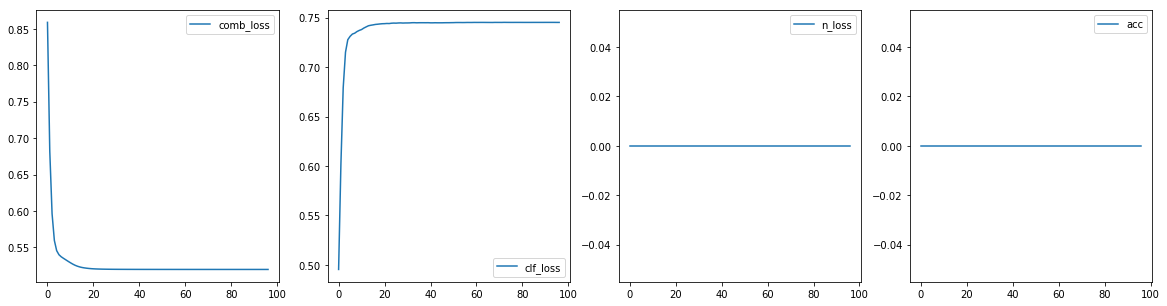

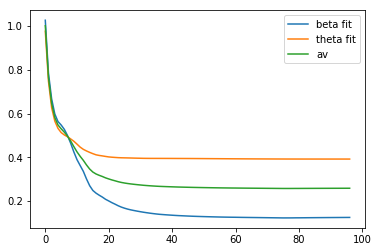

In [63]:
print("elements in h:", len(h))
for tup in h:
    print(tup)

comb_loss, clf_loss, n_loss, acc = zip(*h)


fig = plt.gcf()
#     plt.xlabel("#iterations")
#     plt.ylabel("fit error (RMSE)")
#     plt.suptitle("Neural-MLTM Parameter Fitting")
#     plt.title("(skills=5, items=10, students=100)")
fig, axes = plt.subplots(nrows=1, ncols=4)
axes[0].plot(comb_loss, label="comb_loss")
axes[1].plot(clf_loss, label="clf_loss")
axes[2].plot(n_loss, label="n_loss")
axes[3].plot(acc, label="acc")

fig.set_size_inches(20, 5)
for i in [0,1,2,3]:
    axes[i].legend()
plt.show()

av_fit_rmses = []
for b,th in zip(b_fit_rmses, th_fit_rmses):
    av = (b+th)/2.0
    av_fit_rmses.append(av)
    
plt.plot(b_fit_rmses, label="beta fit")
plt.plot(th_fit_rmses, label="theta fit")
plt.plot(av_fit_rmses, label="av")
plt.legend()
plt.show()
# fig = plt.gcf()
# fig.set_size_inches(8, 5)
# plt.xlabel("#iterations")
# plt.ylabel("fit error (RMSE)")
# plt.suptitle("Neural-MLTM Parameter Fitting")
# plt.title("(skills=5, items=10, students=100)")
# plt.legend()
# plt.show()


In [61]:
real_wgtz = array([ q.betas for q in qs ])
pred_wgtz = q_table.get_weights()[0]
chosen, min_total_err, mean_ll, cos_dis = calc_arr_arr_err(real_wgtz, pred_wgtz, max_iter=10)

print("real", real_wgtz)
# print(pred_wgts)
print("out", chosen)
print("best cos distance:", cos_dis)
print("elementwise mae:", min_total_err)
print("mean lead/lag", mean_ll)

real [[ 4.38204521  2.62630346]
 [ 1.          4.03773289]
 [ 1.46104445  3.66638495]
 [ 3.35539     2.44328973]
 [ 4.70213758  1.0627688 ]
 [ 1.37208005  1.        ]
 [ 4.45069456  1.63562287]
 [ 2.57272732  3.63021556]
 [ 1.32332836  1.        ]
 [ 2.16495696  1.        ]
 [ 4.37419211  1.48759253]
 [ 3.7598776   1.19034993]
 [ 1.          1.05224564]
 [ 3.84598356  1.95859639]
 [ 1.12885567  1.81437649]
 [ 4.48218999  2.87567004]
 [ 4.06081793  4.44022194]
 [ 2.56984548  2.99142302]
 [ 1.          4.70292215]
 [ 1.          4.61635101]
 [ 2.53655569  3.91486257]
 [ 2.72513673  2.75985166]
 [ 2.69173658  2.56465966]
 [ 2.19720971  3.0397123 ]
 [ 1.45789443  2.93674834]
 [ 3.2072676   4.26079487]
 [ 1.          2.42158767]
 [ 1.          2.76603377]
 [ 4.3060262   1.        ]
 [ 3.95333326  3.635032  ]]
out [[ 4.56740236  2.41733885]
 [ 1.          4.10868979]
 [ 1.00566018  3.77452087]
 [ 3.43430686  2.20109248]
 [ 4.70903015  1.        ]
 [ 1.12039006  1.        ]
 [ 4.417274    1.6

(30, 2) (30, 2)


/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


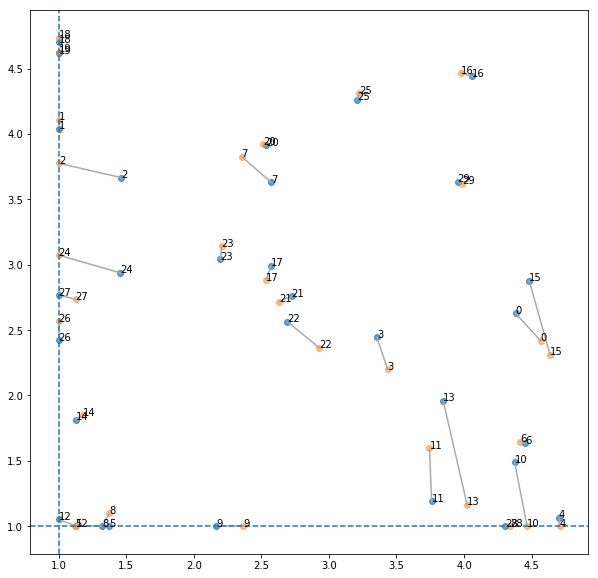

In [64]:
fig = plt.gcf()
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
# pca2 = PCA(n_components=2)
# pca = TSNE(n_components=2)
# pca2 = TSNE(n_components=2)

itemz = array([ q.betas for q in qs ])

itemz_2 = itemz
print(itemz.shape,chosen.shape)
# itemz_2 = pca.fit_transform(itemz_2)
# itemz_2 = MinMaxScaler().fit_transform(itemz_2)

itemz_pred = chosen
#do not use by mistake # itemz_pred = pca2.fit_transform(itemz_pred)
# itemz_pred = pca.transform(itemz_pred)
# itemz_pred = MinMaxScaler().fit_transform(itemz_pred)
# print(itemz_2)

# fig,axs = plt.subplots(1,2)
fig = plt.gcf()
fig.set_size_inches(10, 10)

for x,xh,y,yh in zip(itemz_2[:,0],itemz_pred[:,0],itemz_2[:,1],itemz_pred[:,1]):
    fig.gca().plot([x,xh],[y,yh],color="#aaaaaa")

fig.gca().scatter(itemz_2[:,0], itemz_2[:,1], alpha=0.7)
fig.gca().scatter(itemz_pred[:,0], itemz_pred[:,1], alpha=0.5)

for i, txt in enumerate(itemz_2):
    fig.gca().annotate(i, (itemz_2[i,0], itemz_2[i,1]))

for i, txt in enumerate(itemz_pred):
    fig.gca().annotate(i, (itemz_pred[i,0], itemz_pred[i,1]))

fig.gca().axvline(x=baseline, linestyle="--")
fig.gca().axhline(y=baseline, linestyle="--")
    
fig.show()